Analyse results of moseq model on Mo's dataset under dilation of given mice to see the relationship between gross morphological variable and syllables

Relies on the moseq syllables and computed in `kpms_under_dilation.ipynb`

In [1]:
%load_ext autoreload
%autoreload 3 --print

In [2]:
import os; os.environ['JAX_PLATFORM_NAME'] = 'cpu'

In [3]:
import kpsn_moseq_explore.lib.kpms_custom_io as cio
from kpsn_moseq_explore import viz
from kpsn_moseq_explore import lib

import jax.tree_util as pt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib as jl
import re

sns.set_context("paper")

### Dilated session within Mo's full dataset

In [8]:
import keypoint_moseq as kpms

root_dir = '/home/kaf200/datta/kai/mph/moseq-explore'

project_dir = f'{root_dir}/kpms_projects/modata'
data_dir = f'{root_dir}/recordings/modata'

model_name = 'allsubj_continued'
results_dir = f'{root_dir}/kpms_results/modata/{model_name}'

config = lambda: kpms.load_config(project_dir)

In [8]:
base_results = jl.load(f'{results_dir}/pop-results.p')

In [9]:
# sessions and scale factors run through kpms
sessions = ['3wk_m0']
scale_factors = [0.75, 1.25, 1.5]

scaled_results = lambda session, scale_factor: jl.load(
    f'{results_dir}/dilation/{session}-f{scale_factor}-results.p')[session]

# syllables used in the population and/or by a scaled session
sylls = np.unique(np.concatenate(
    [np.unique(r['syllable'])
     for r in base_results.values()] +
    [np.unique(scaled_results(session, scale_factor)['syllable'])
     for session in sessions for scale_factor in scale_factors]
    ))

# count percent of frames in which a syllable is used
base_frame_pcts = {
    session: np.array([
        (base_results[session]['syllable'] == s).mean() for s in sylls])
    for session in base_results}

scaled_frame_pcts = {
    session: {scale_factor:
            np.array([
                (scaled_results(session, scale_factor)['syllable'] == s
                 ).mean() for s in sylls])
        for scale_factor in scale_factors}
    for session in sessions}

# usage in seconds
fps = 30
session_lengths = {
    session: base_results[session]['syllable'].shape[0] * (1/fps)
    for session in base_results}

In [10]:
# are there syllables used in the scaled sessions not used in the original?
# and vice versa?
# >example of very obvious deviation
# >(can we look at log usages?)
# also note subset where both usages are nonzero

used_sylls = {}
for session in sessions:
    used_sylls[session] = base_frame_pcts[session] != 0
    for scale_factor in scale_factors:
        scaled_sess = scaled_frame_pcts[session][scale_factor]
        base_sess = base_frame_pcts[session]

        introduced_sylls = np.where((scaled_sess != 0) &(base_sess == 0))[0]
        dropped_sylls = np.where((scaled_sess == 0) & (base_sess != 0))[0]
        used_sylls[session] &= scaled_sess != 0
        
        print(f"{session}-f{scale_factor}:",
            f"introduced = {len(introduced_sylls)}",
            f"dropped = {len(dropped_sylls)}")
        for syll in introduced_sylls: print(f'+{syll}, 0 -> %.3f (%.2f s)' % (
            scaled_sess[syll], scaled_sess[syll] * session_lengths[session]))
        for syll in dropped_sylls:    print(f'-{syll}, %.5f (%.2f s) -> 0' % (
            base_sess[syll], base_sess[syll] * session_lengths[session]))
    
    used_sylls[session] = np.where(used_sylls[session])[0]
        

3wk_m0-f0.75: introduced = 1 dropped = 4
+67, 0 -> 0.002 (1.90 s)
-9, 0.00008 (0.10 s) -> 0
-10, 0.00181 (2.17 s) -> 0
-33, 0.00011 (0.13 s) -> 0
-66, 0.00003 (0.03 s) -> 0
3wk_m0-f1.25: introduced = 3 dropped = 3
+25, 0 -> 0.000 (0.23 s)
+64, 0 -> 0.002 (2.30 s)
+67, 0 -> 0.006 (7.33 s)
-9, 0.00008 (0.10 s) -> 0
-10, 0.00181 (2.17 s) -> 0
-61, 0.00248 (2.97 s) -> 0
3wk_m0-f1.5: introduced = 4 dropped = 3
+30, 0 -> 0.001 (1.03 s)
+48, 0 -> 0.000 (0.40 s)
+64, 0 -> 0.000 (0.30 s)
+67, 0 -> 0.010 (11.43 s)
-9, 0.00008 (0.10 s) -> 0
-10, 0.00181 (2.17 s) -> 0
-61, 0.00248 (2.97 s) -> 0


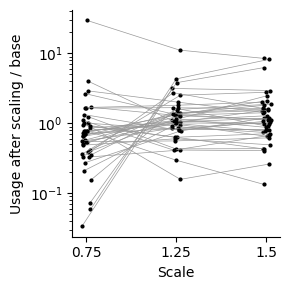

In [11]:
session = '3wk_m0'
fig, ax = plt.subplots(1, 1, figsize = (3, 3))
for syll in used_sylls[session]:
    jtr = np.random.uniform(-0.05, 0.05, len(scale_factors))
    plt.plot(
        np.arange(len(scale_factors)) + jtr,
        [(scaled_frame_pcts[session][scale_factor][syll] /
            base_frame_pcts[session][syll]) 
         for scale_factor in scale_factors],
        '-o', lw = 0.5, ms = 2, markeredgecolor = 'k',
        markerfacecolor = 'k', color = '.6')

ax.set_yscale('log')
ax.set_xticks(np.arange(len(scale_factors)))
ax.set_xticklabels(scale_factors)
ax.set_xlabel("Scale")
ax.set_ylabel("Usage after scaling / base")
sns.despine()
plt.tight_layout()

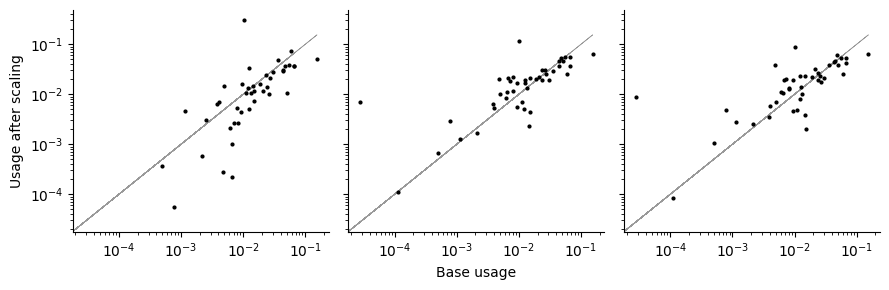

In [12]:
fig, ax = plt.subplots(1, len(scale_factors), figsize = (len(scale_factors) * 3, 3),
    sharex = True, sharey = True)

for i_f, scale_factor in enumerate(scale_factors):
    ax[i_f].plot(
        base_frame_pcts[session], base_frame_pcts[session],
        lw = 0.5, color = '.6')
    
    ax[i_f].plot(
        base_frame_pcts[session], scaled_frame_pcts[session][scale_factor],
        'o', ms = 2, color = 'k')
    
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_ylabel("Usage after scaling")
ax[len(scale_factors) // 2].set_xlabel("Base usage")

sns.despine()
plt.tight_layout()
    

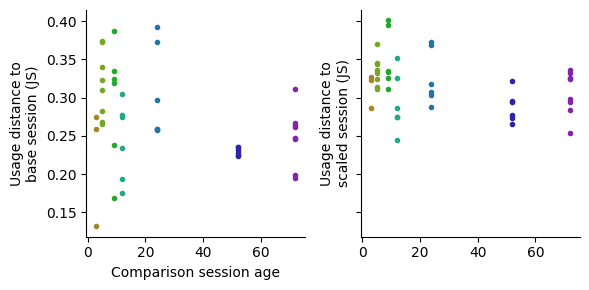

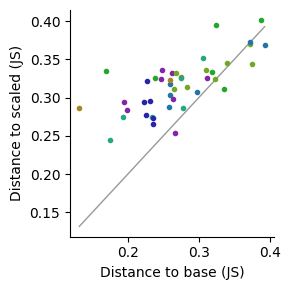

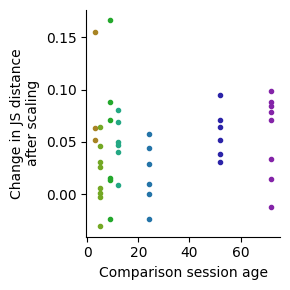

In [46]:
session = '3wk_m0'
scale_factor = 1.25

from scipy.spatial import distance
sessions = [sess for sess in base_results.keys() if sess != session]
ages = [int(s.split('w')[0]) for s in sessions]
jsds_scaled = [distance.jensenshannon(
            base_frame_pcts[sess], scaled_frame_pcts[session][scale_factor] 
        ) for sess in sessions]
jsds_base = [distance.jensenshannon(
            base_frame_pcts[sess], base_frame_pcts[session]
        ) for sess in sessions]

unique_ages = np.unique(ages)
age_pal = dict(zip(unique_ages, sns.hls_palette(l = 0.4, n_colors = len(unique_ages) + 2)[1:-1]))
fig, ax = plt.subplots(1, 2, figsize = (6, 3), sharey = True)
for age, jsd_scaled, jsd_base in zip(ages, jsds_scaled, jsds_base):
    ax[0].plot([age], [jsd_base],   'o', ms = 3, color = age_pal[age])    
    ax[1].plot([age], [jsd_scaled], 'o', ms = 3, color = age_pal[age])
ax[0].set_xlabel("Comparison session age")
ax[0].set_ylabel("Usage distance to\nbase session (JS)")
ax[1].set_ylabel("Usage distance to\nscaled session (JS)")
sns.despine()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (3, 3))
ax.plot(np.sort(jsds_base), np.sort(jsds_base), '-', color = '.6', lw = 1)
for age, jsd_scaled, jsd_base in zip(ages, jsds_scaled, jsds_base):
    ax.plot([jsd_base], [jsd_scaled], 'o', ms = 3, color = age_pal[age])
ax.set_xlabel("Distance to base (JS)")
ax.set_ylabel("Distance to scaled (JS)")
sns.despine()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize = (3, 3))
for age, jsd_scaled, jsd_base in zip(ages, jsds_scaled, jsds_base):
    ax.plot([age], [jsd_scaled - jsd_base], 'o', ms = 3, color = age_pal[age])
ax.set_xlabel("Comparison session age")
ax.set_ylabel("Change in JS distance\nafter scaling")
sns.despine()
plt.tight_layout()
plt.show()

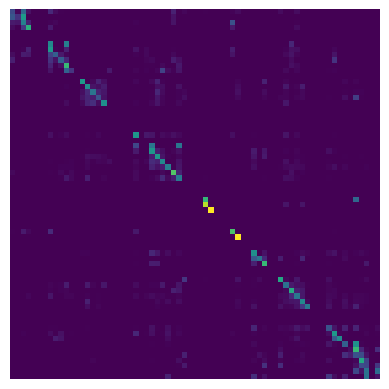

In [29]:
session = '3wk_m0'
scale_factor = 1.25

from kpsn_moseq_explore import viz
confusion = viz.confusion.usage_matrix(
    base_results[session]['syllable'],
    scaled_results(session, scale_factor)['syllable'],
    sylls)

fig, ax = plt.subplots()
ax.imshow(confusion)
ax.set_axis_off()
plt.show()


### Twoscale dataset

##### Setup / load

In [4]:
root_dir = '/home/kaf200/datta/kai/mph/moseq-explore'
dataset = 'blscale_wk3_to52'

project_dir = f'{root_dir}/kpms_projects/{dataset}'
if not os.path.isdir(project_dir):
    print(f"Warning: project directory does not exist:\n{project_dir}")

model_name = 'slds_fit'
results_dir = lambda run_name: f'{root_dir}/kpms_results/{dataset}/{model_name}_{run_name}'
data_dir = f'{root_dir}/recordings/modata'
plot_dir = f'{root_dir}/plots/notebook/kpmsdil-{dataset}'

config = lambda: kpms.load_config(project_dir)

In [5]:
results = jl.load(f'{results_dir("main")}/pop-results.p')

##### Measure stats

In [8]:
recs = [k.split('f')[0][:-1] for k in results.keys() if k.endswith("f1")]
scale_factors = [1, 1.3]

syll_results = {s: r['syllable'] for s, r in results.items()}
sylls = viz.confusion.tree_unique(syll_results)

sessions = np.array(list(syll_results.keys()))
order_scale_outer = [sessions.tolist().index(f"{rec}_f{sf}") for sf in scale_factors for rec in recs]
order_rec_outer   = [sessions.tolist().index(f"{rec}_f{sf}") for rec in recs for sf in scale_factors]

frame_pcts = {
    sess: (r[None, :] == sylls[:, None]).mean(axis = 1)
    for sess, r in syll_results.items()}


In [42]:
jsd_matrix = np.zeros([len(syll_results), len(syll_results)])
for row_sess_i, row_sess in enumerate(sessions):
    for col_sess_i in range(row_sess_i + 1):
        if row_sess_i == col_sess_i: pass

        col_sess = sessions[col_sess_i]
        jsd = distance.jensenshannon(frame_pcts[row_sess], frame_pcts[col_sess])
        jsd_matrix[row_sess_i, col_sess_i] = jsd
        jsd_matrix[col_sess_i, row_sess_i] = jsd
        
jsd_scale_outer = jsd_matrix[order_scale_outer, :][:, order_scale_outer]
jsd_rec_outer   = jsd_matrix[order_rec_outer,   :][:, order_rec_outer]

##### Scale is the major variable

Reloading 'kpsn_moseq_explore.viz.confusion'.


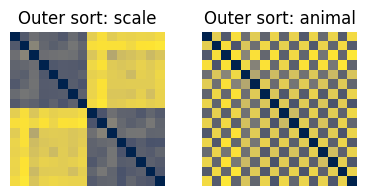

In [87]:
fig, ax = plt.subplots(1, 2, figsize = (4, 2))

ax[0].imshow(jsd_scale_outer, cmap = 'cividis')
ax[1].imshow(jsd_rec_outer, cmap = 'cividis')
for a in ax:
    a.set_xticks([]); a.set_yticks([])
sns.despine(bottom=True, left=True)
ax[0].set_title("Outer sort: scale")
ax[1].set_title("Outer sort: animal")
plt.tight_layout()

Reloading 'kpsn_moseq_explore.viz.confusion'.


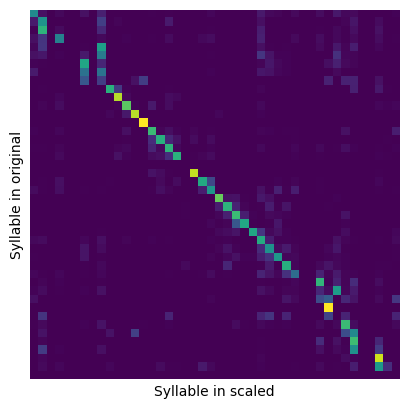

In [103]:

confusion, order_clustered = viz.confusion.usage_matrix(
    np.concatenate([syll_results[f'{rec}_f1'] for rec in recs]),
    np.concatenate([syll_results[f'{rec}_f1.3'] for rec in recs]),
    sylls)

fig, ax = plt.subplots()
ax.imshow(confusion)
ax.set_ylabel("Syllable in original")
ax.set_xlabel("Syllable in scaled")
ax.set_xticks([]); ax.set_yticks([])
sns.despine(left = True, bottom = True)
plt.show()

Each row: percent of frames originally assigned syllable $n$ that get assigned syllable $m$ (column) in the scaled video

##### Syllable tajectories

In [97]:
coordinates, confidences = lib.datasets.twoscale(dataset, data_dir, config(), format = False)

Loading keypoints: 100%|████████████████| 44/44 [00:02<00:00, 16.97it/s]


Cohort: 5wk
Sessions (pre scale): ['5wk_m0', '5wk_m1', '5wk_m3', '5wk_m2', '5wk_m4', '5wk_m7', '5wk_m6', '5wk_m5']
Generated scaled sessions f1.3


In [ ]:
from keypoint_moseq.util import get_typical_trajectories
syll_trajs = get_typical_trajectories(coordinates, results, density_sample = False, min_frequency = 0, min_duration=0)

Reloading 'keypoint_moseq.util'.


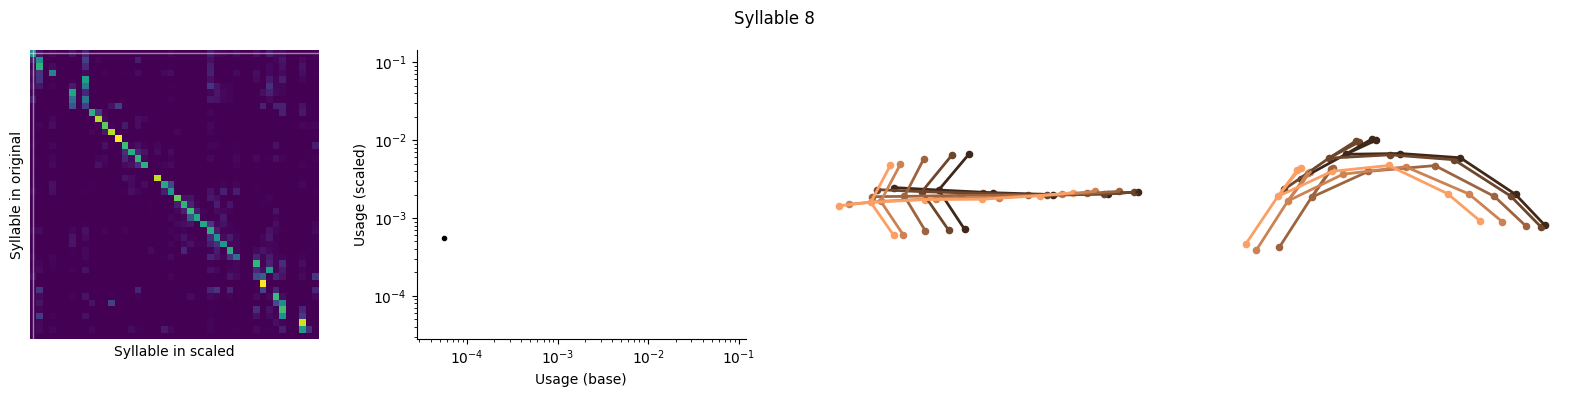

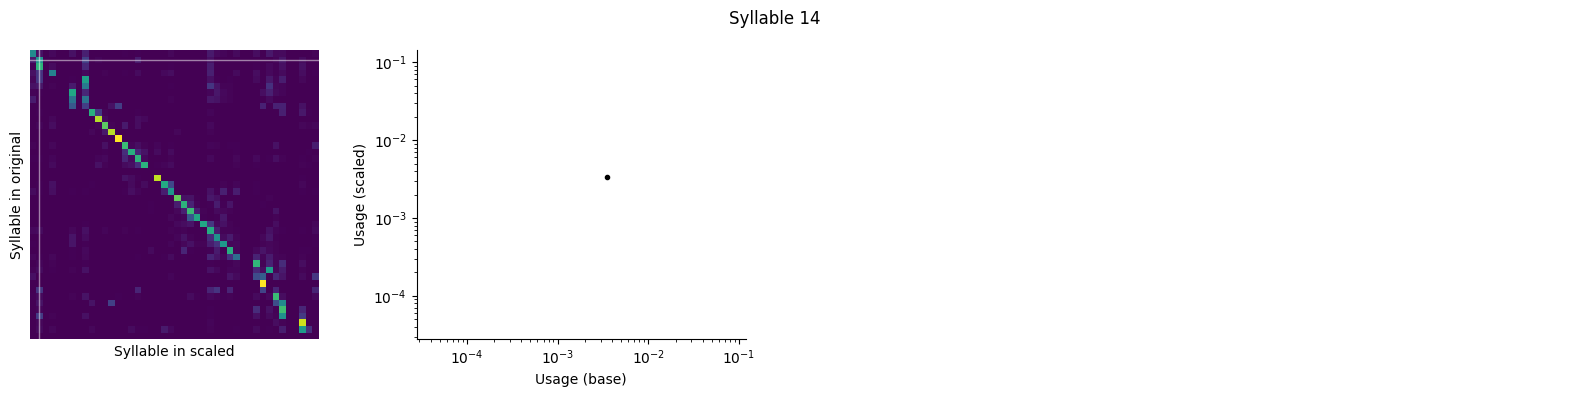

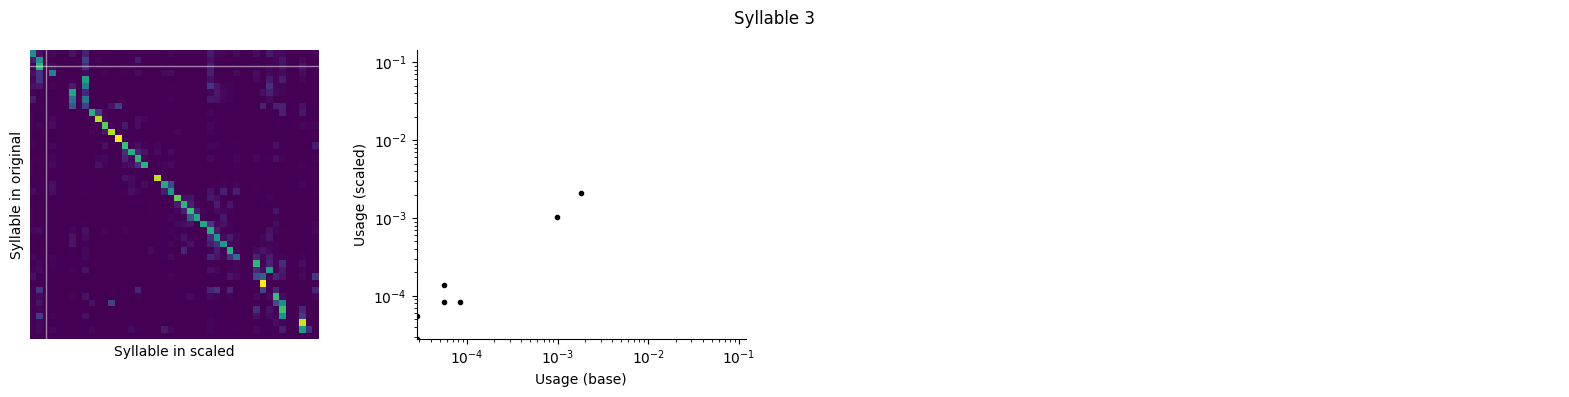

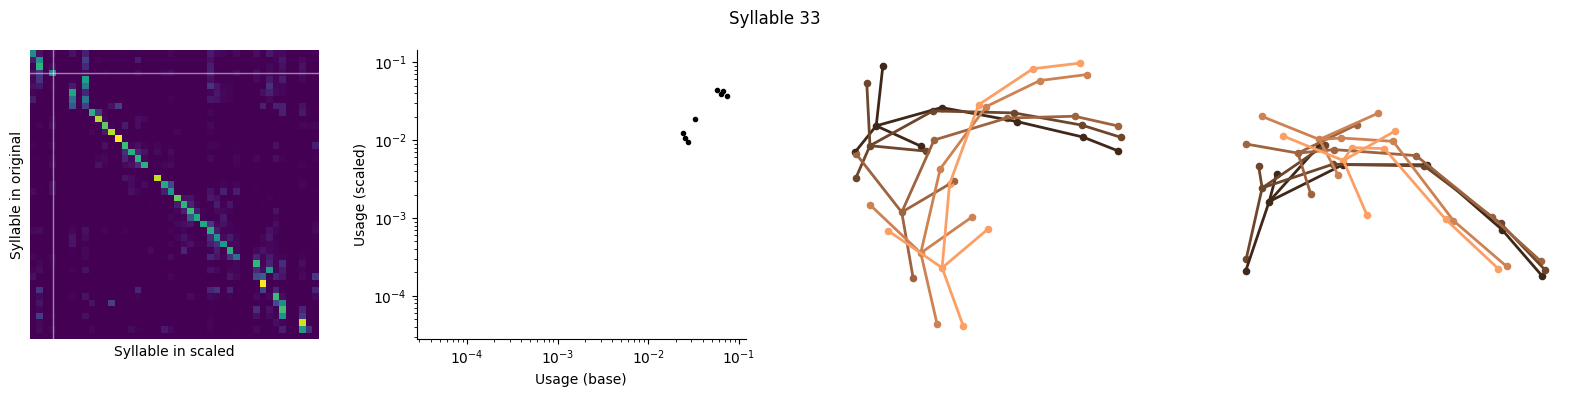

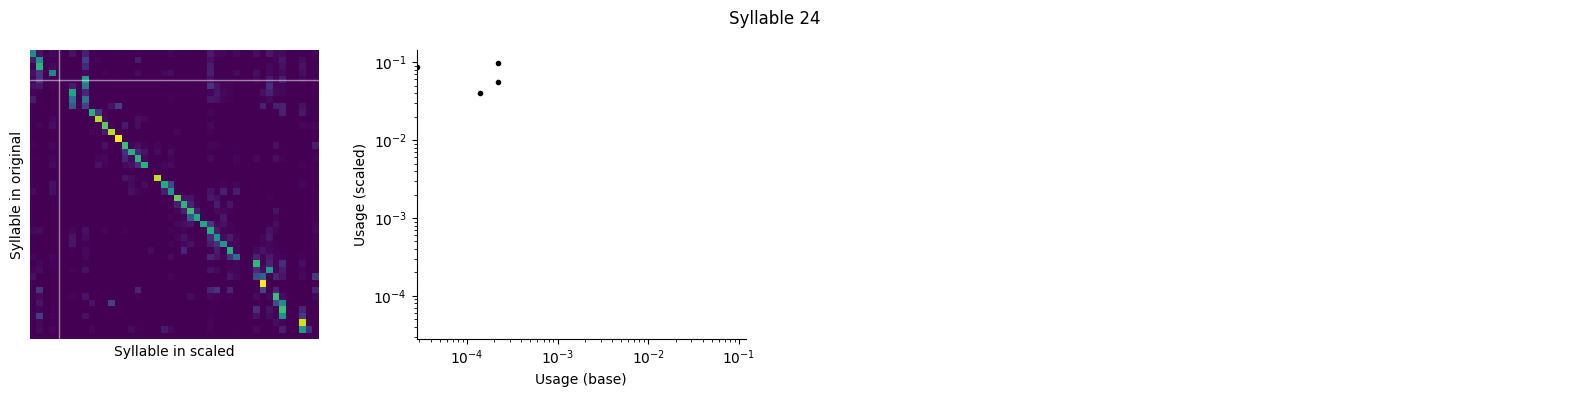

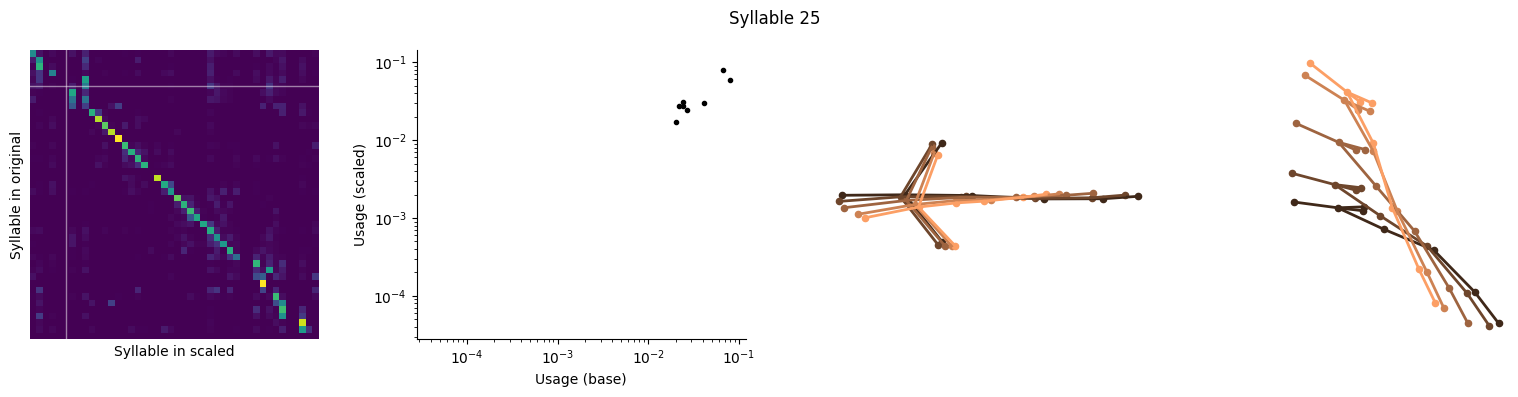

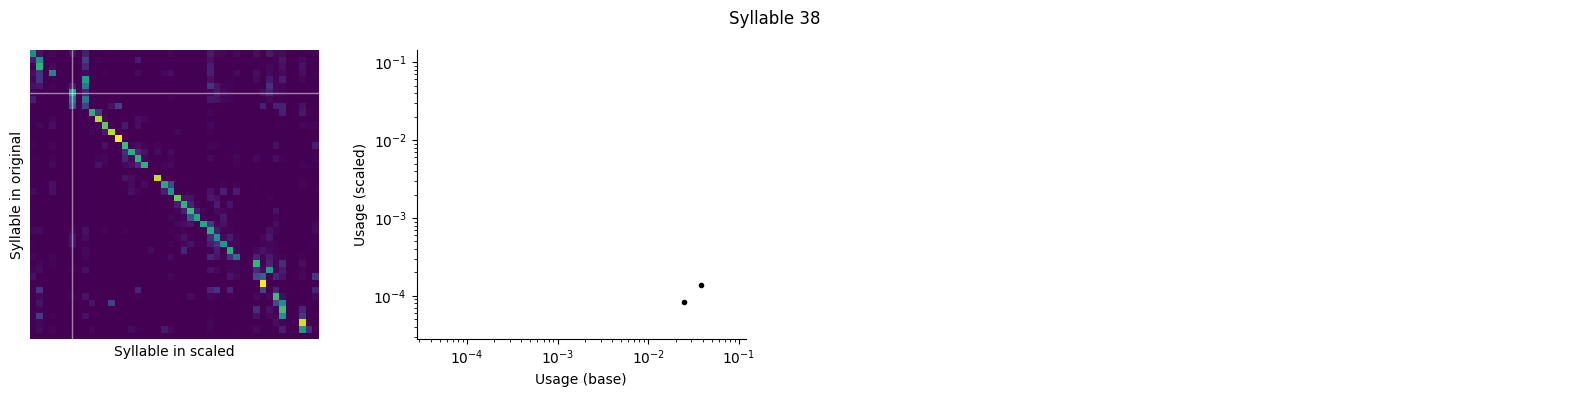

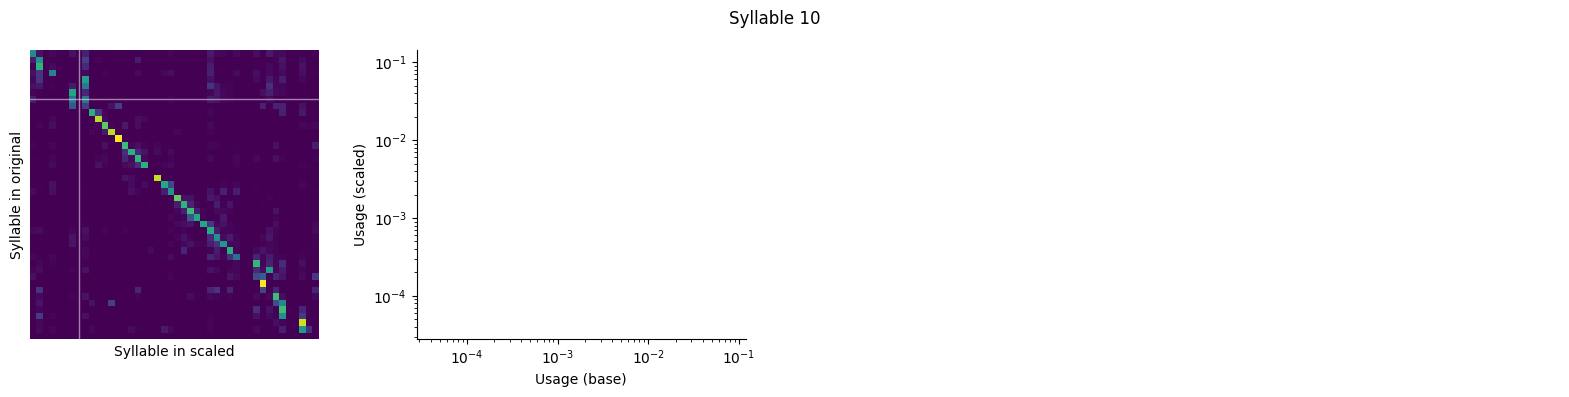

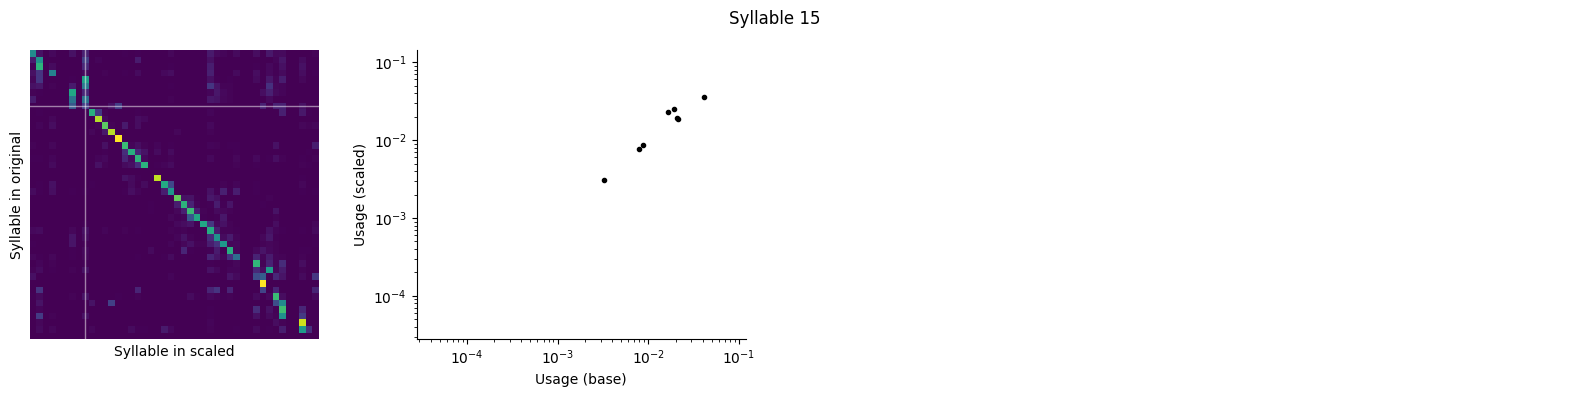

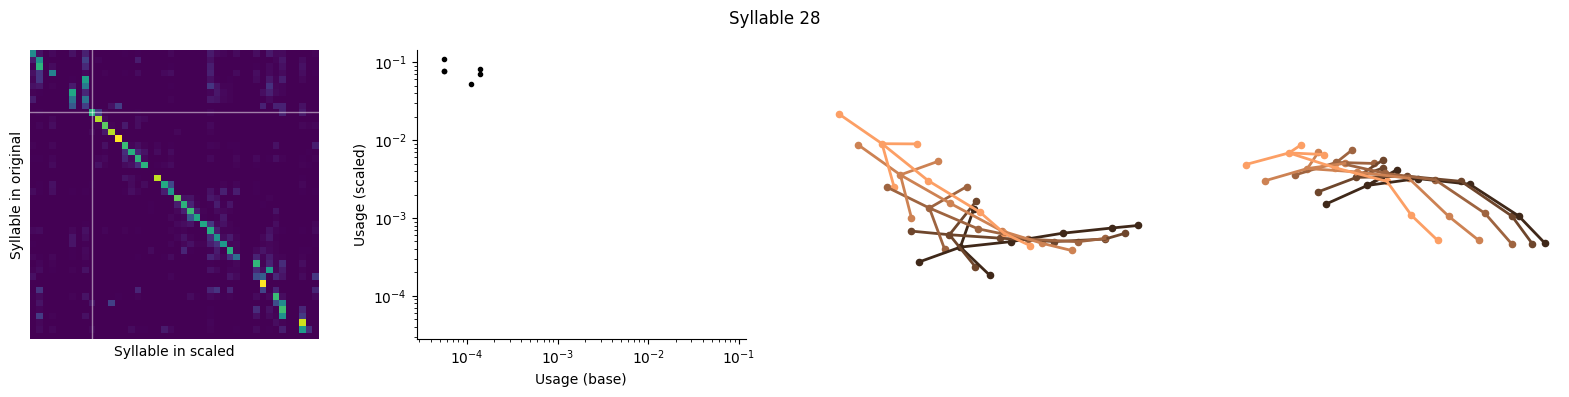

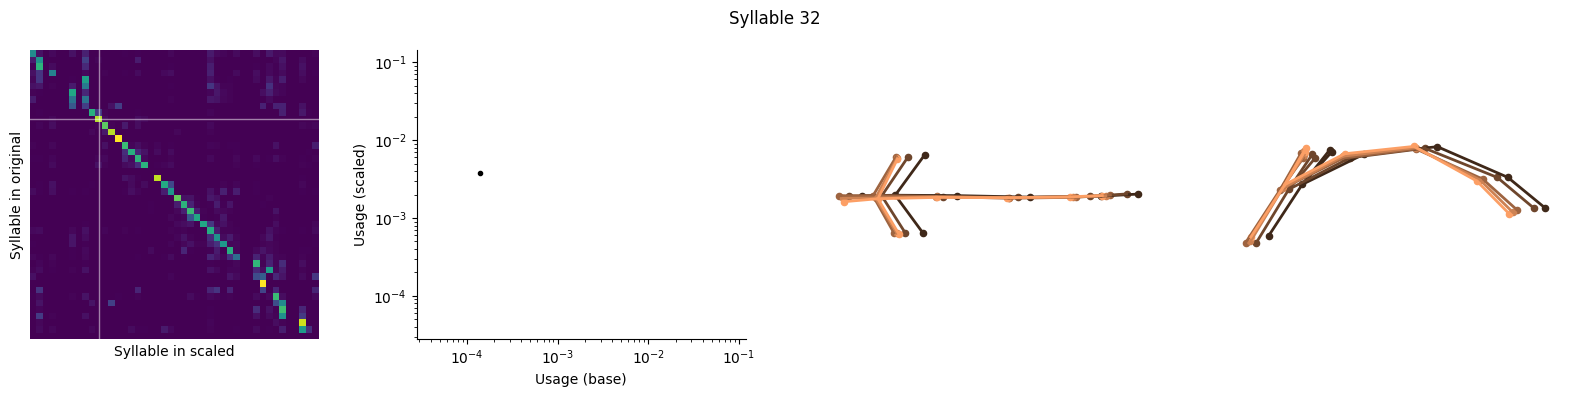

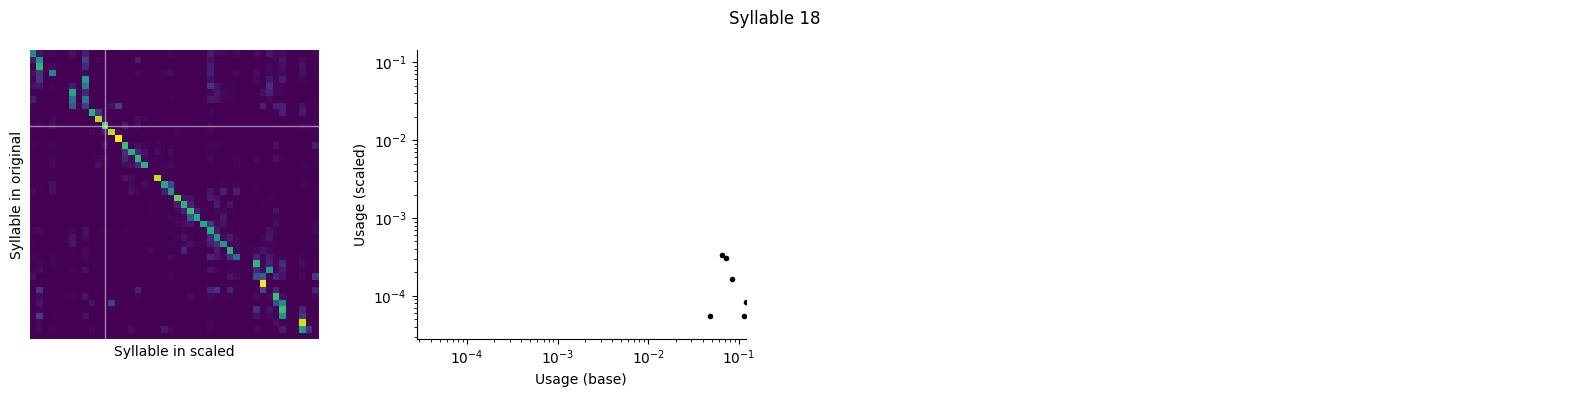

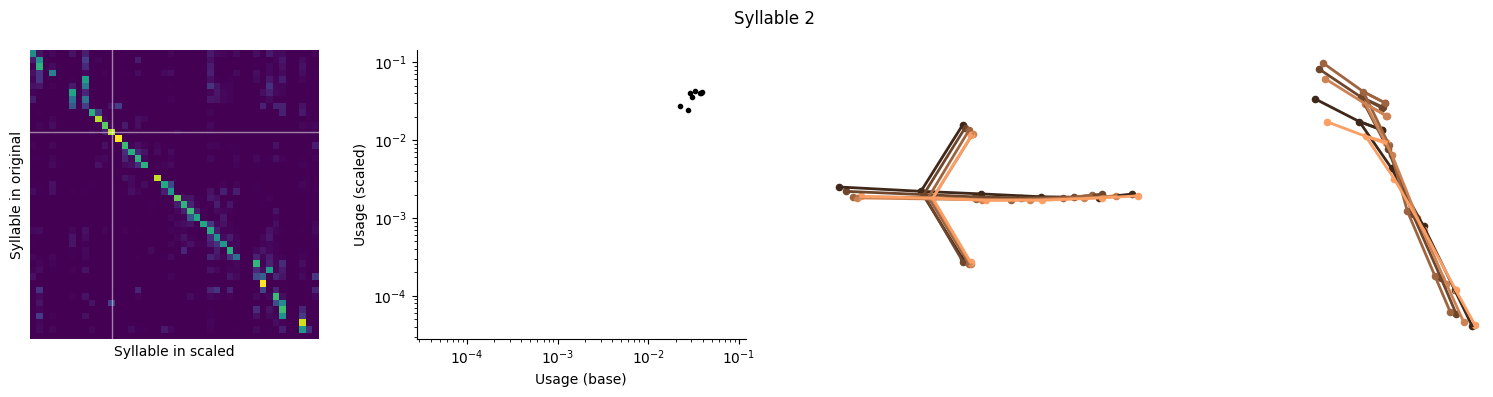

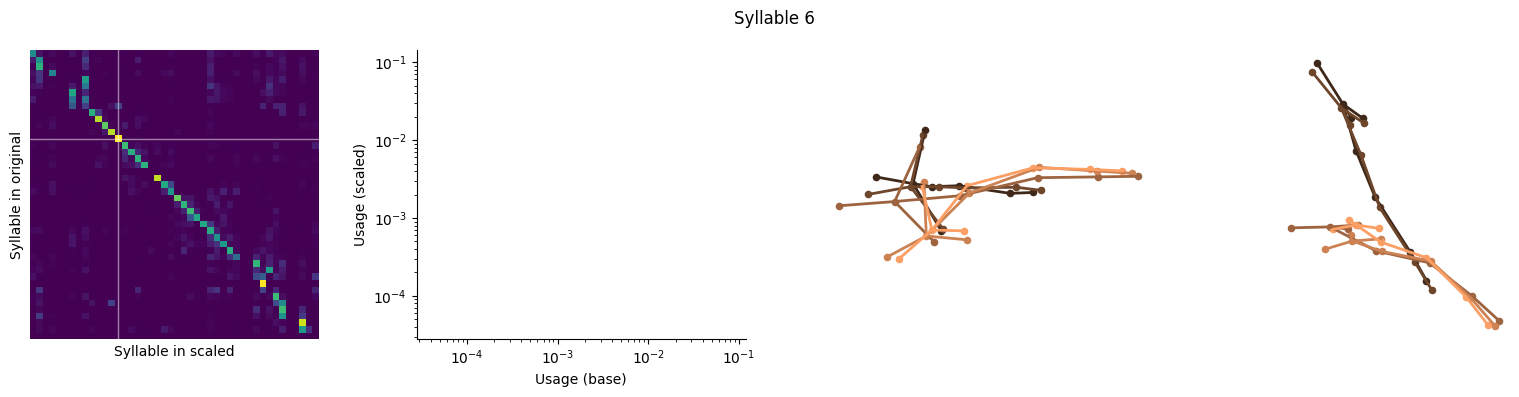

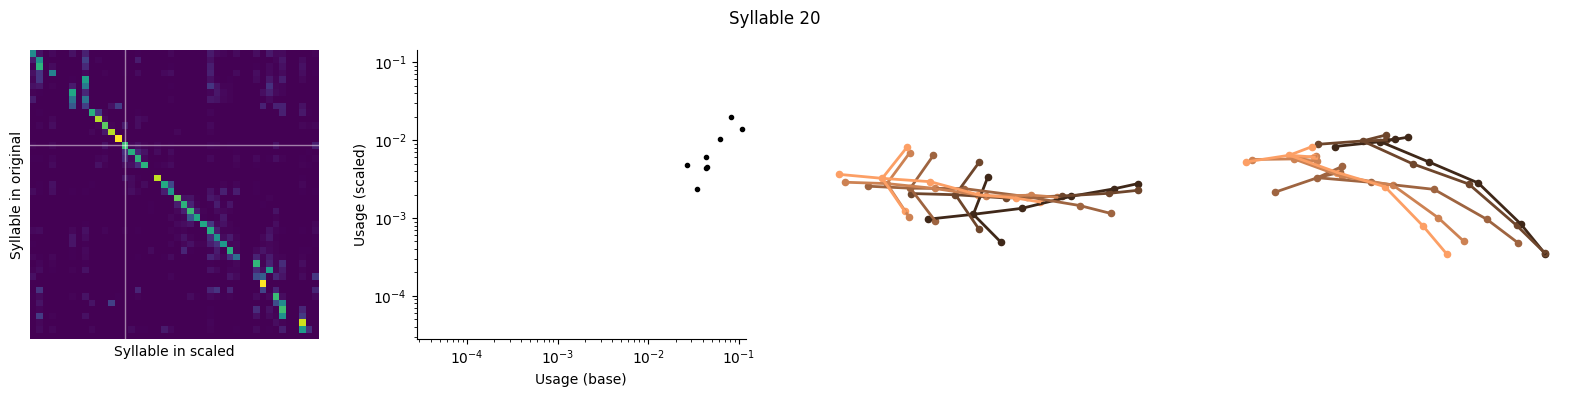

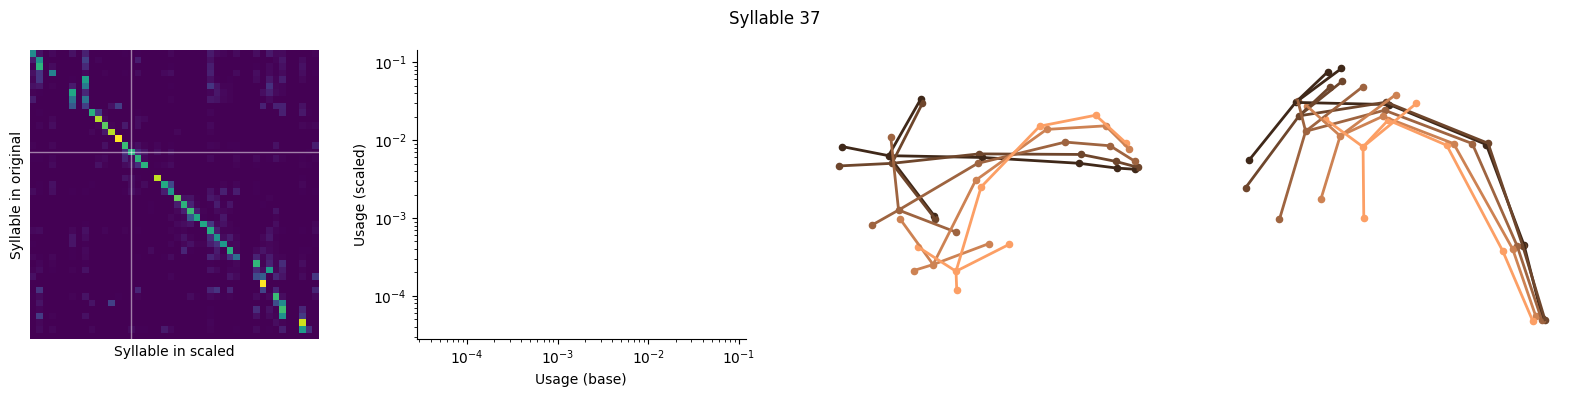

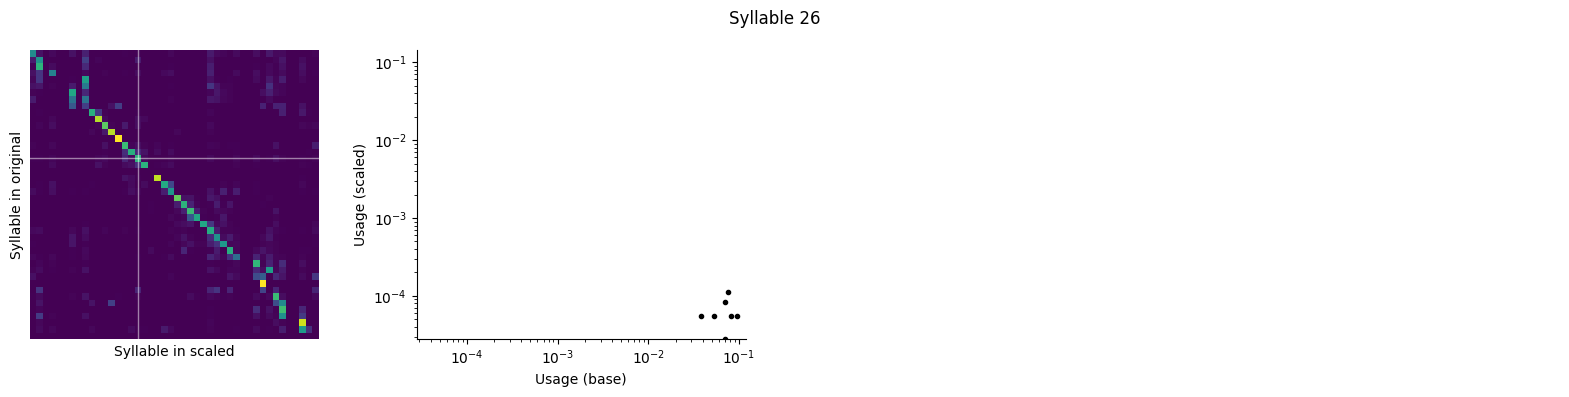

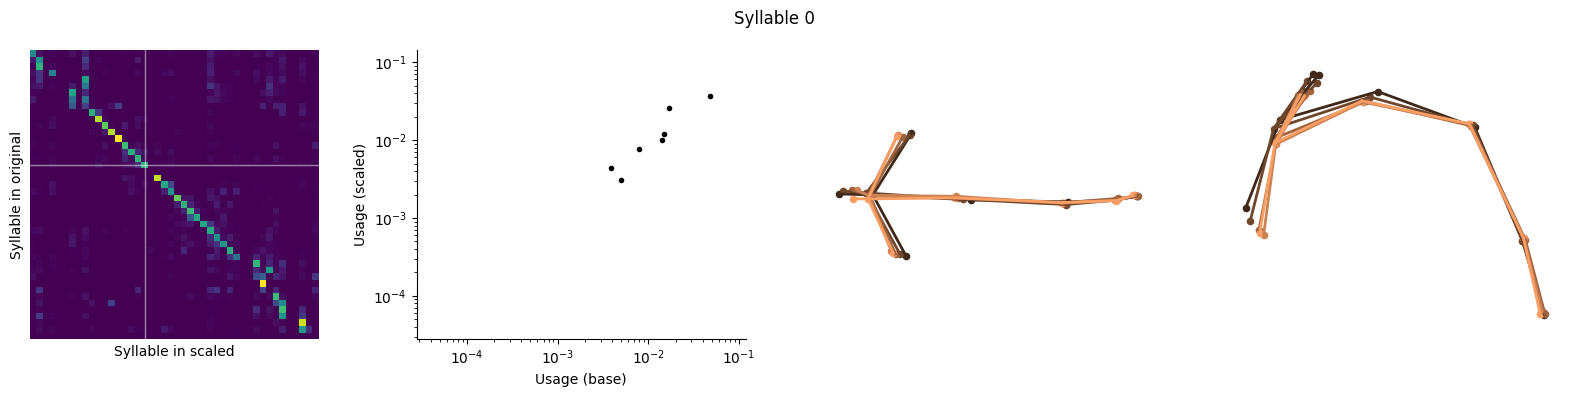

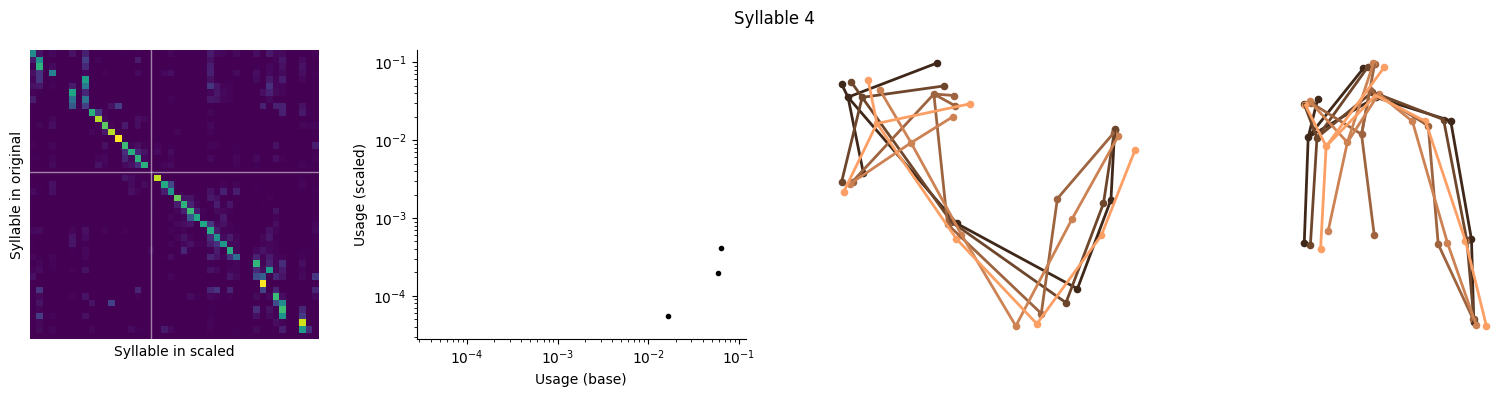

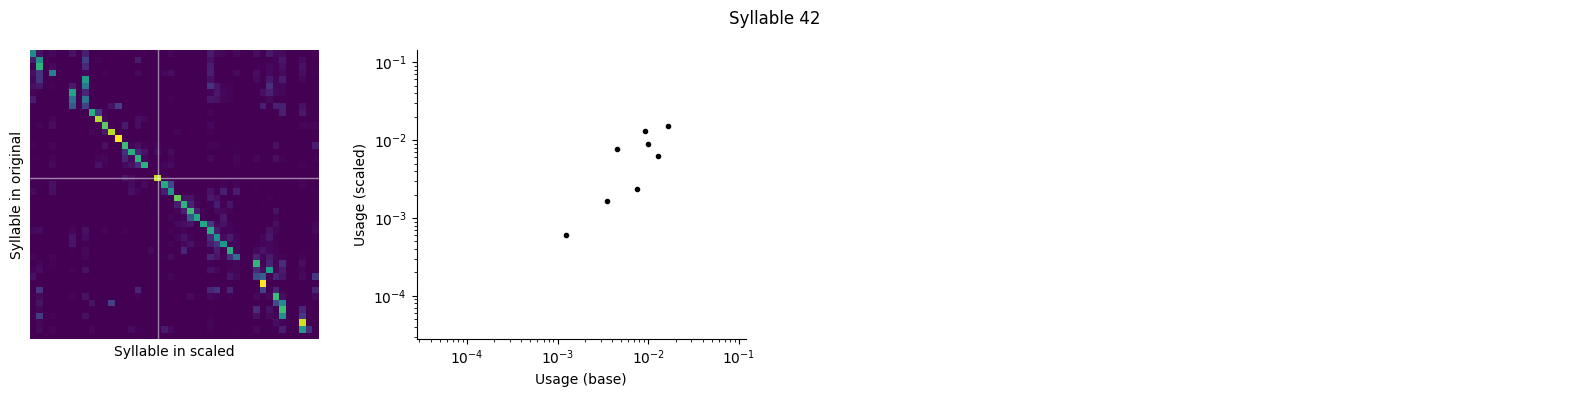

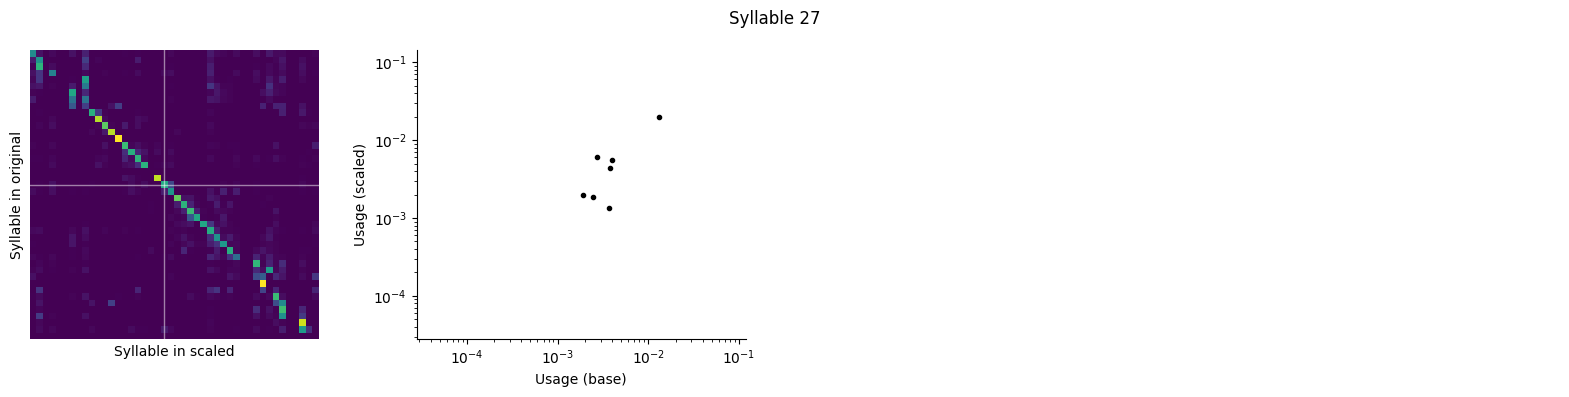

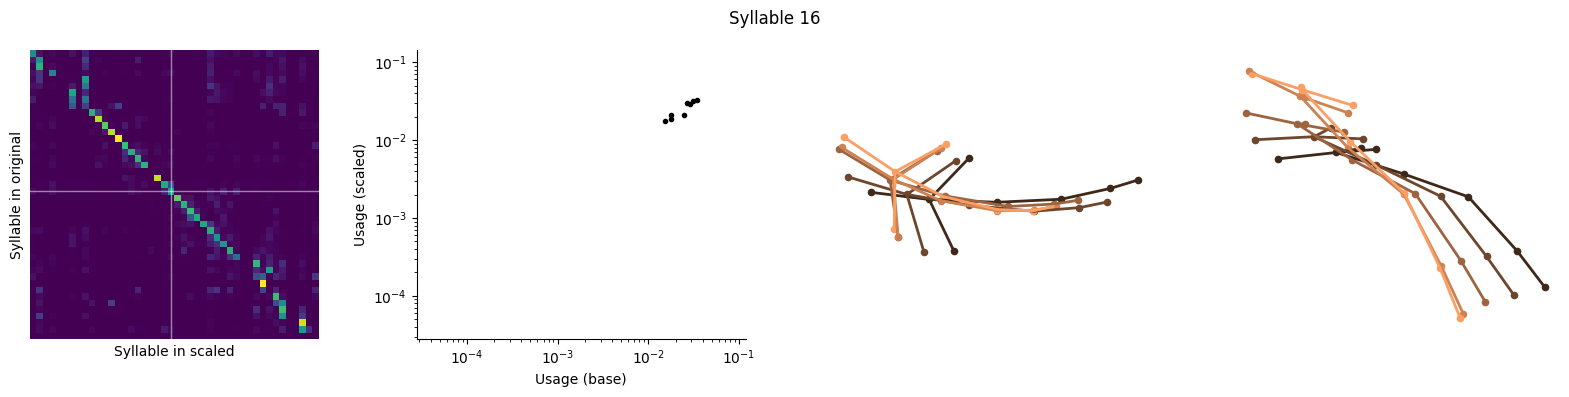

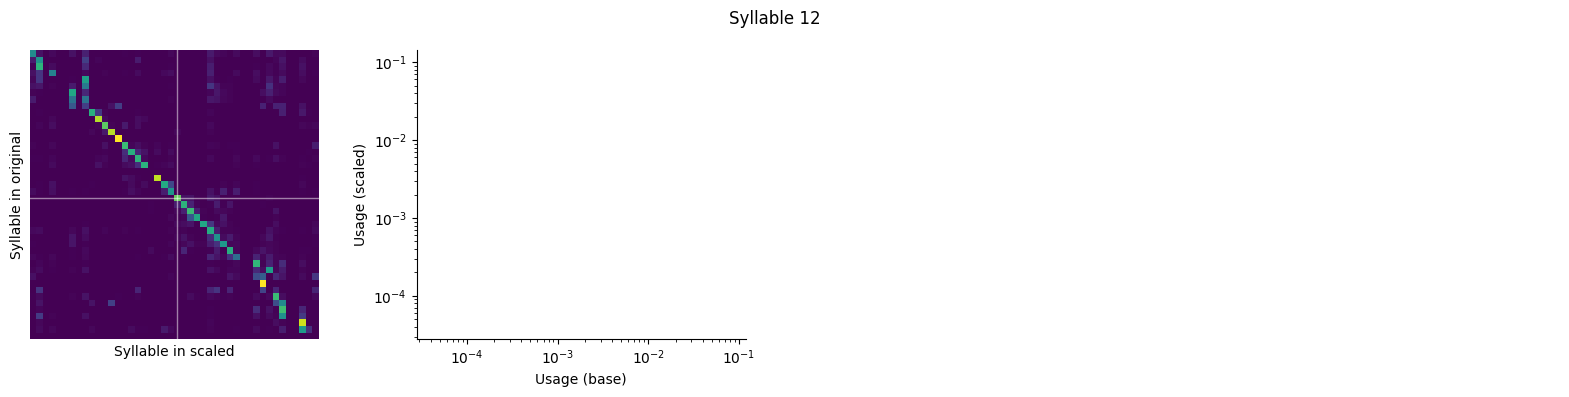

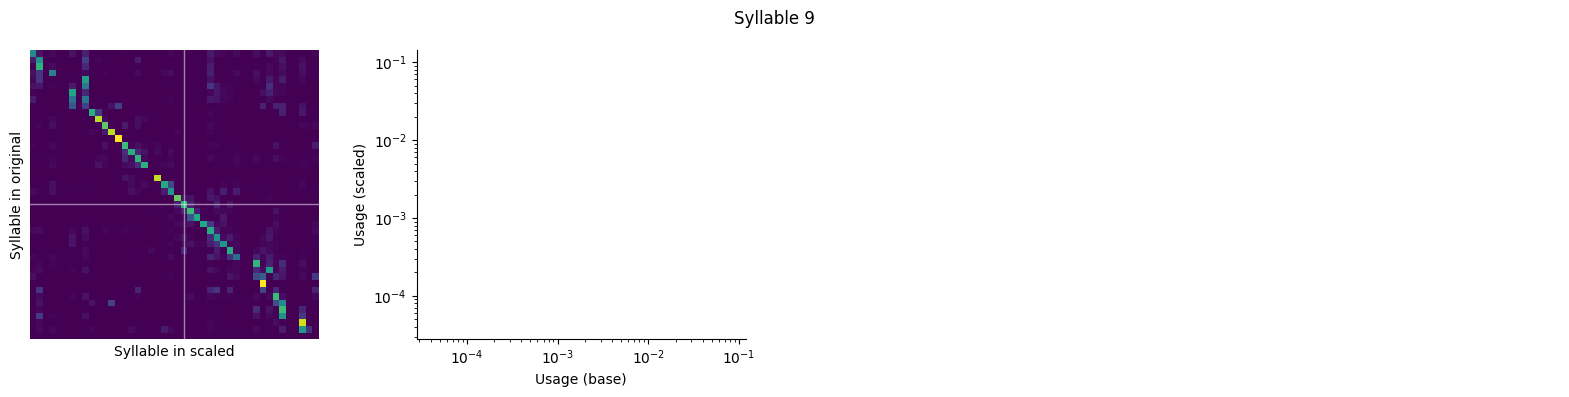

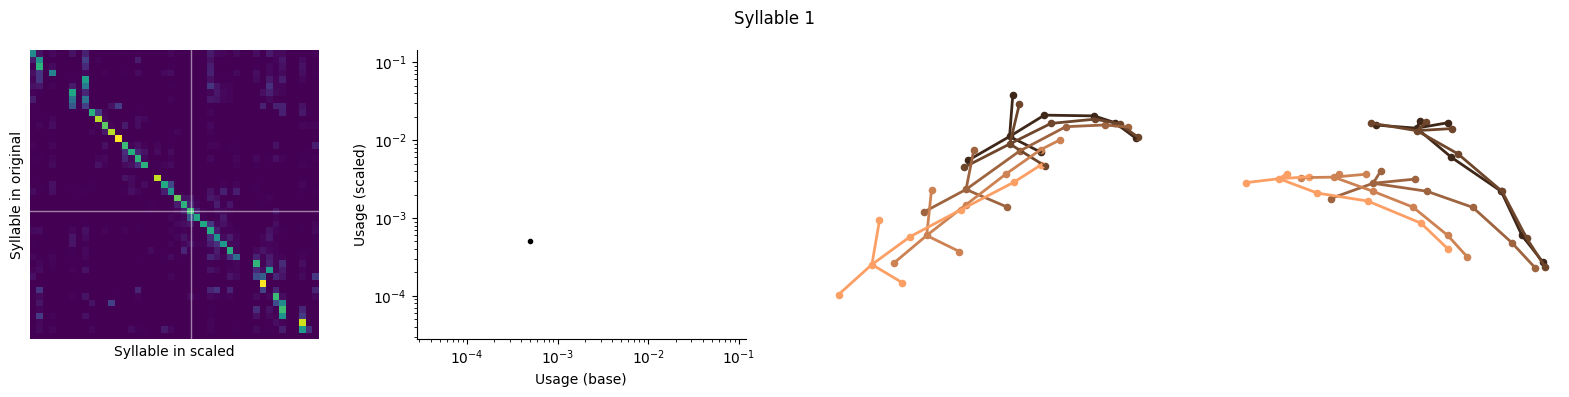

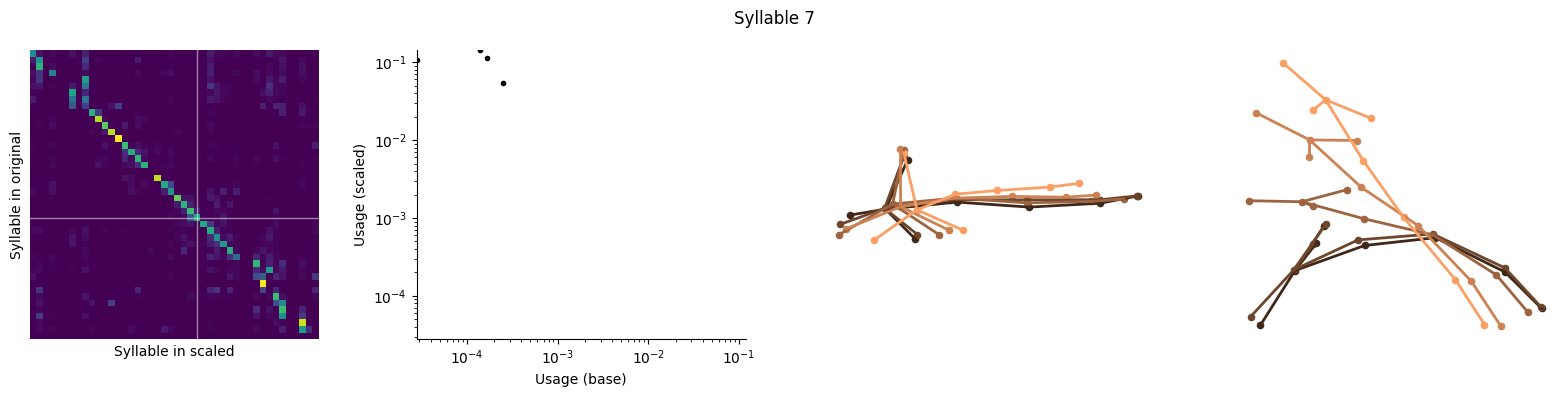

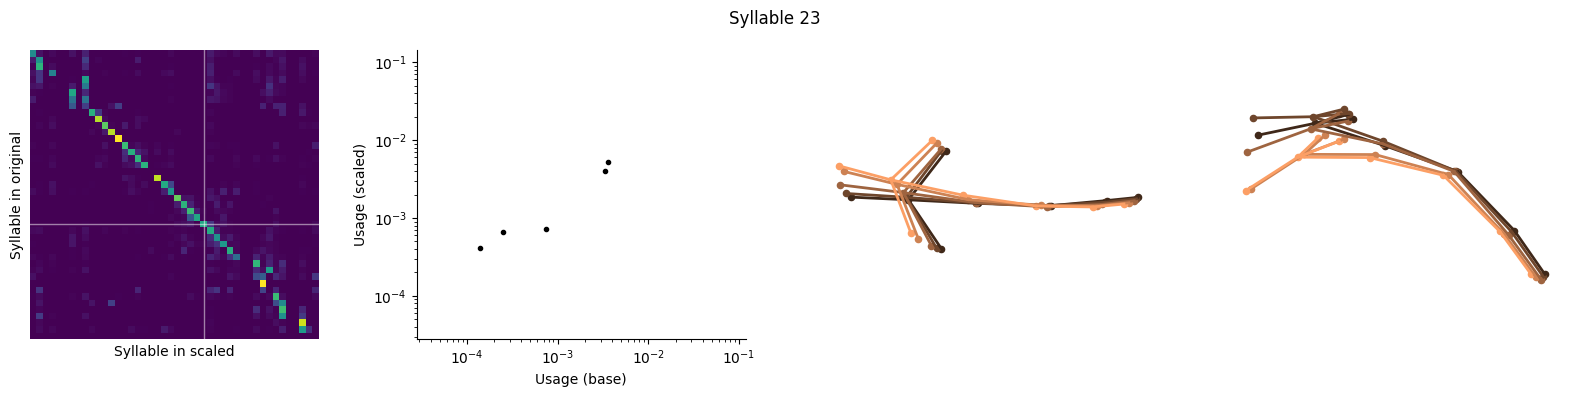

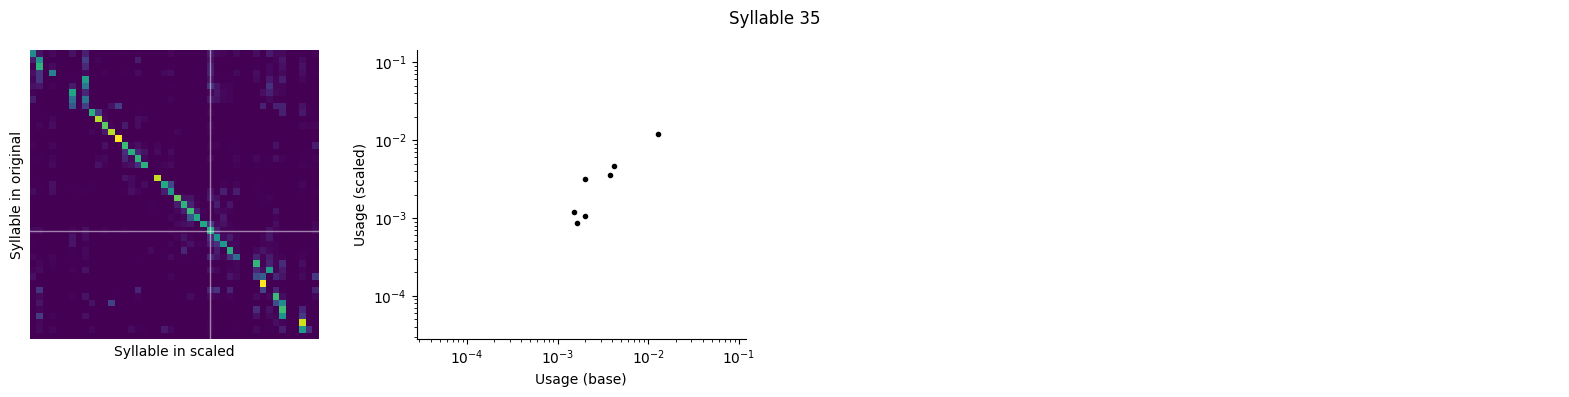

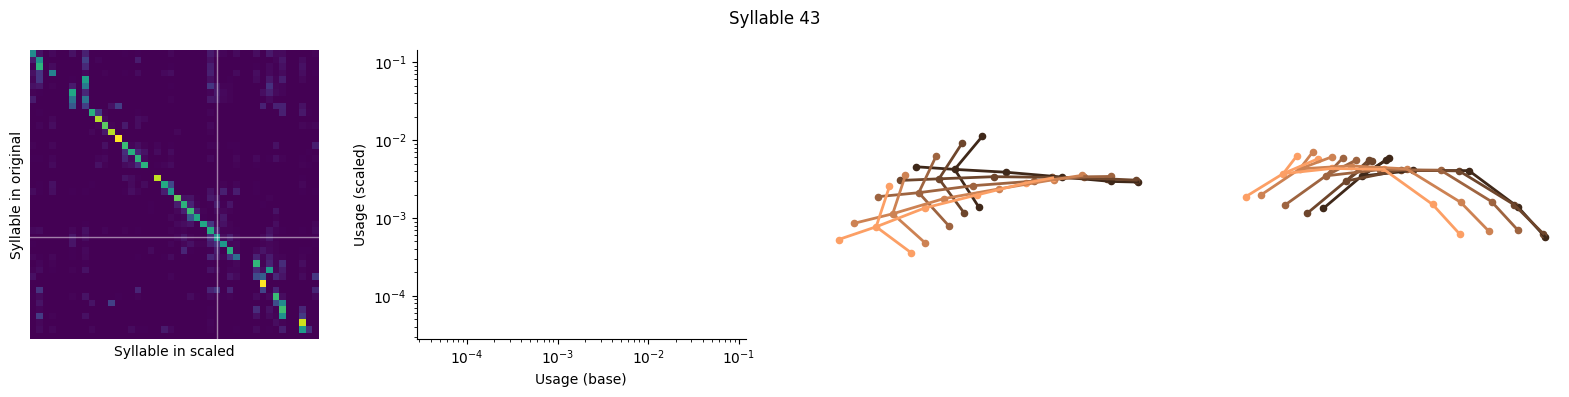

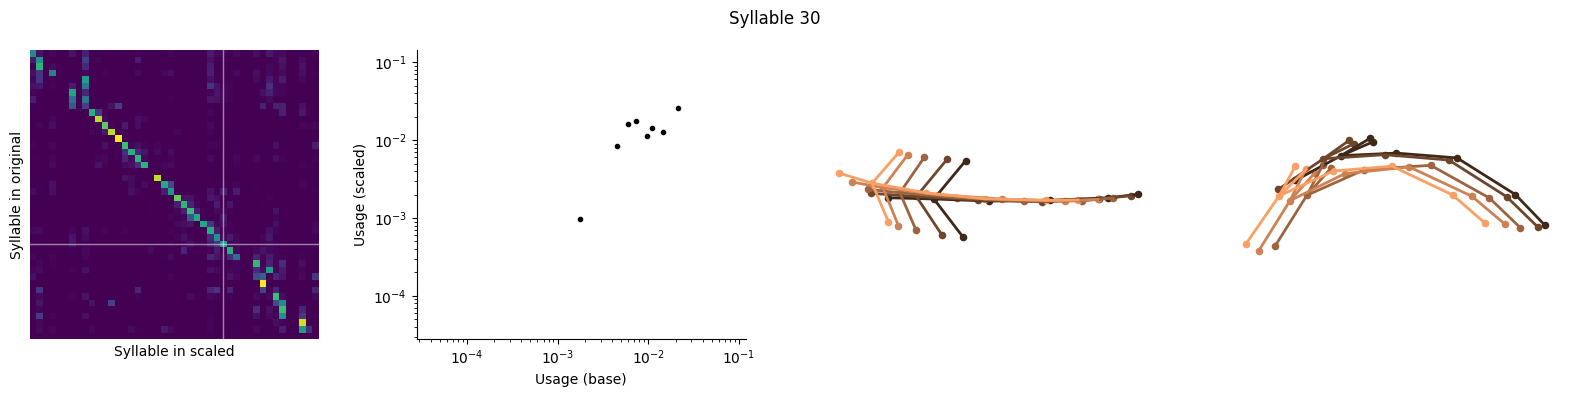

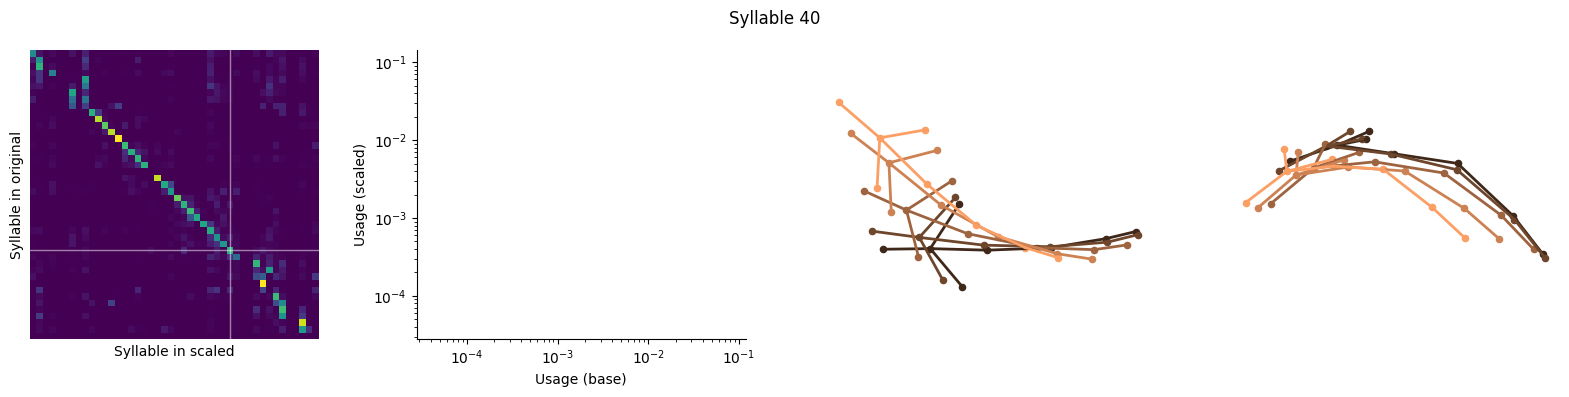

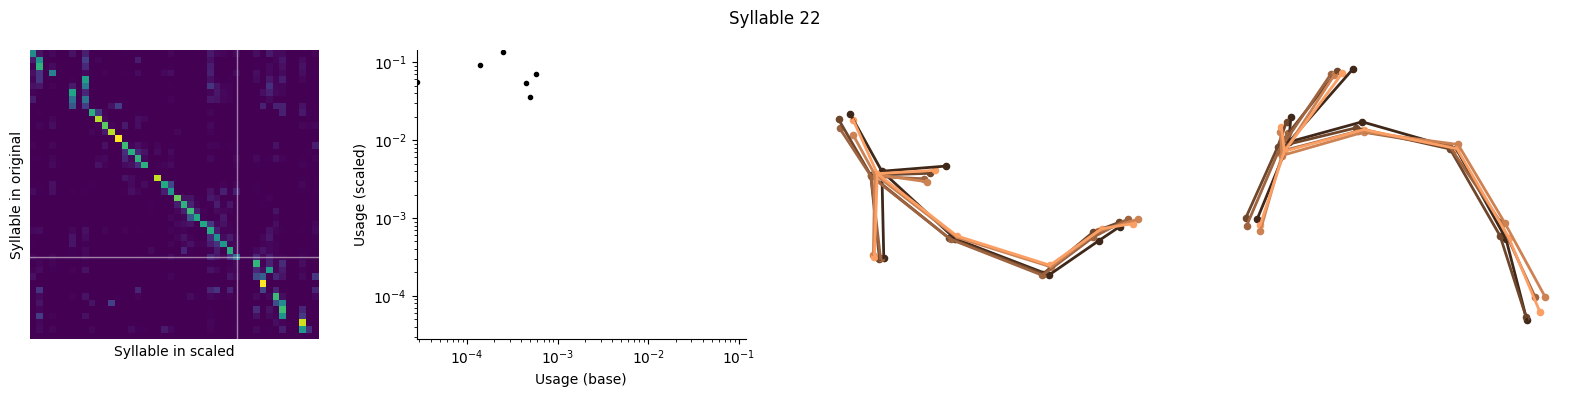

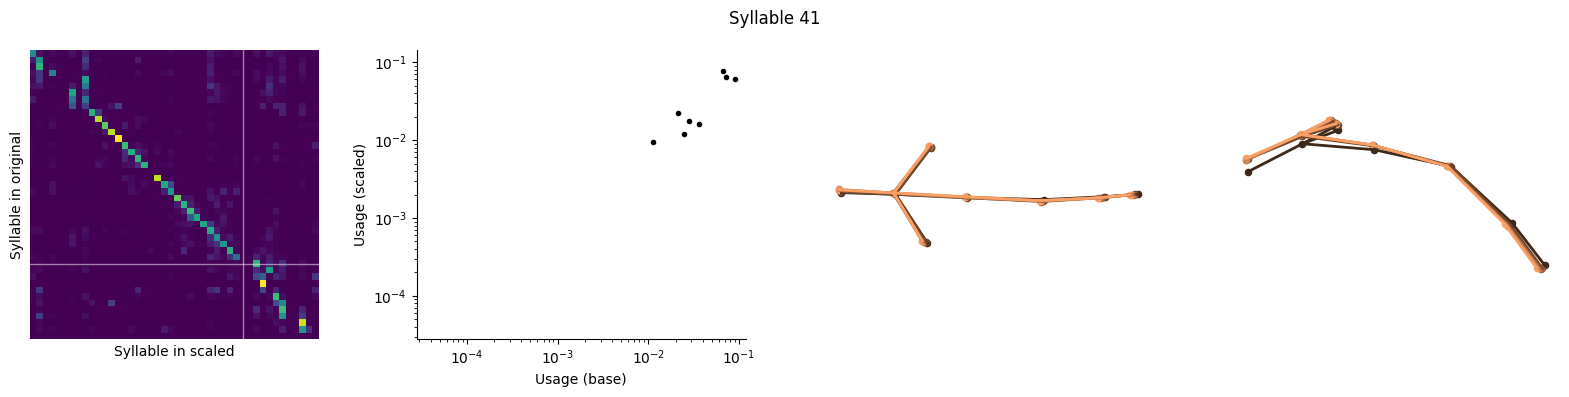

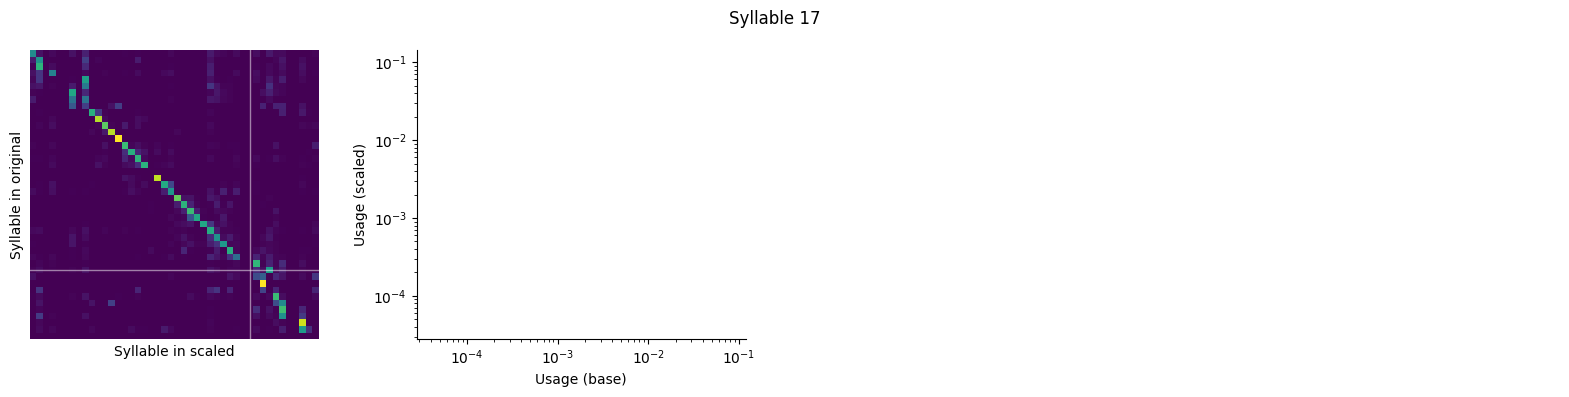

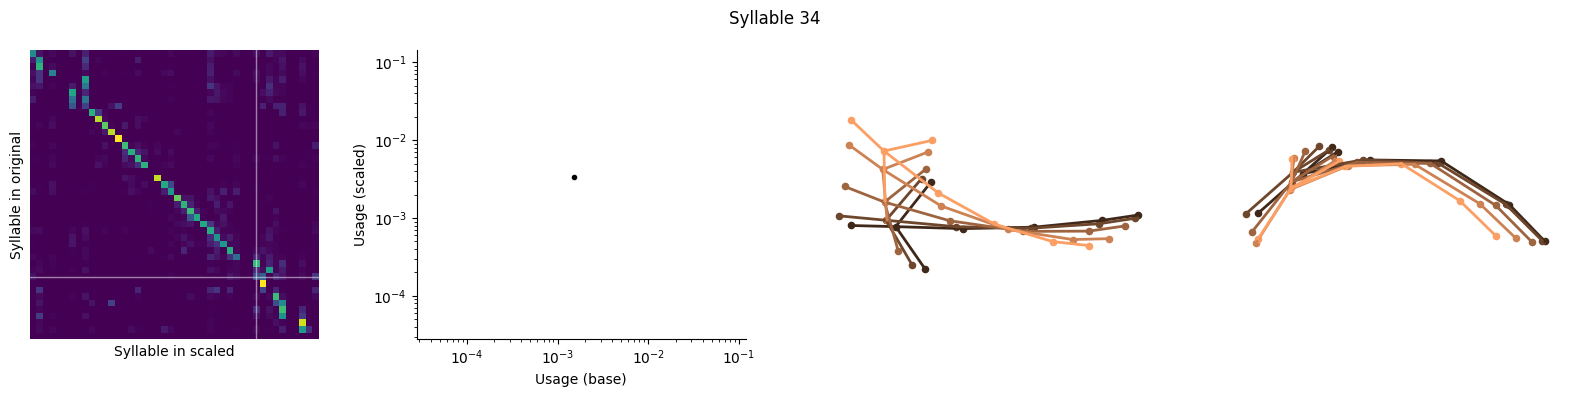

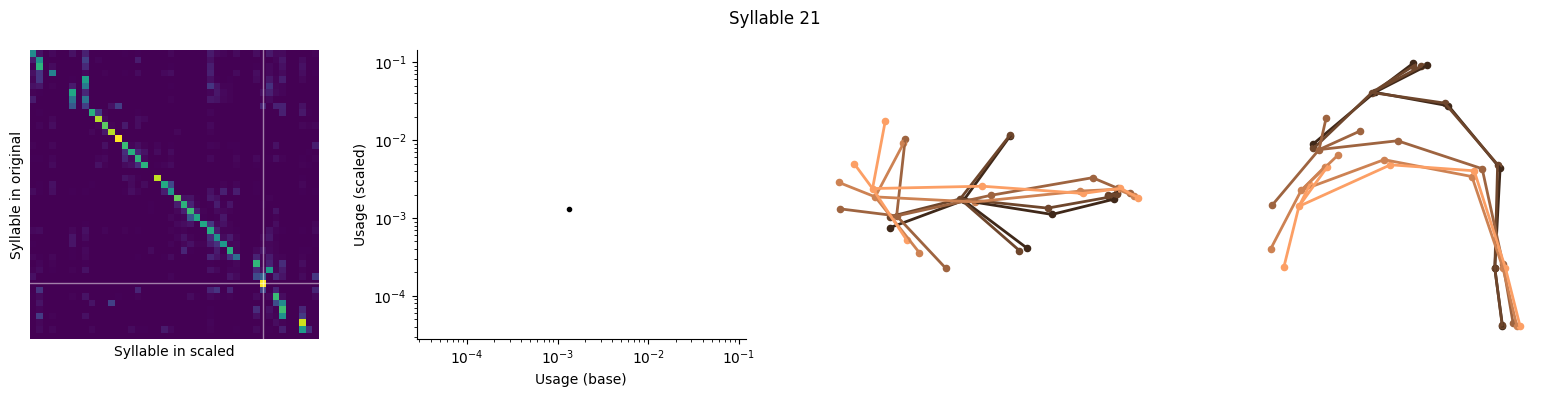

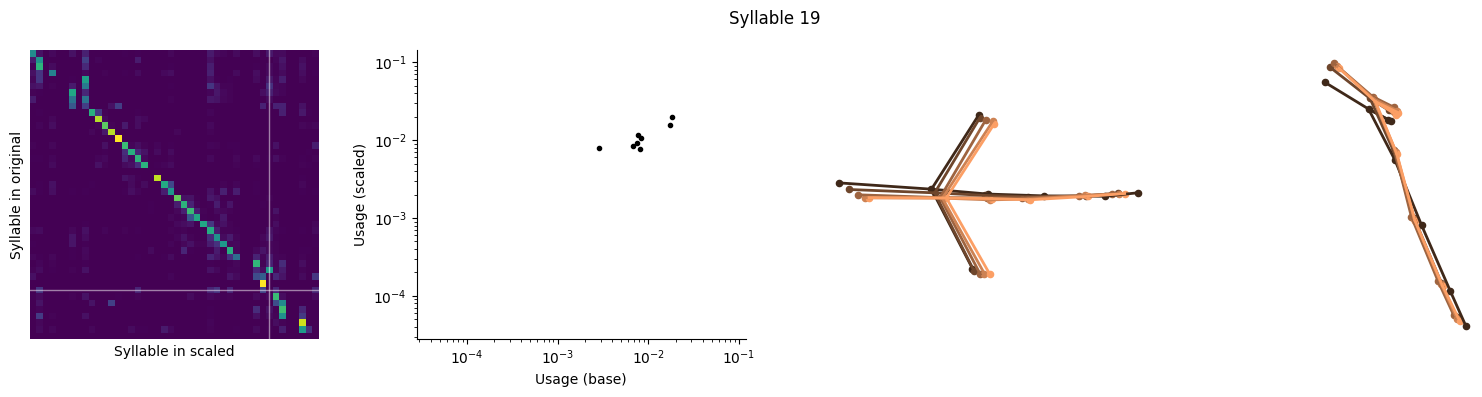

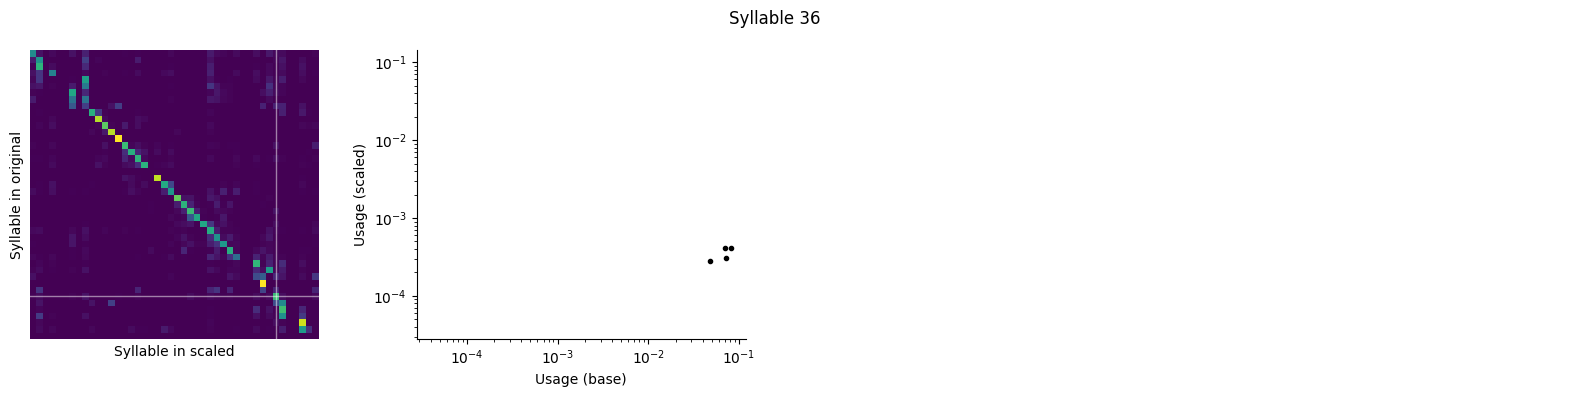

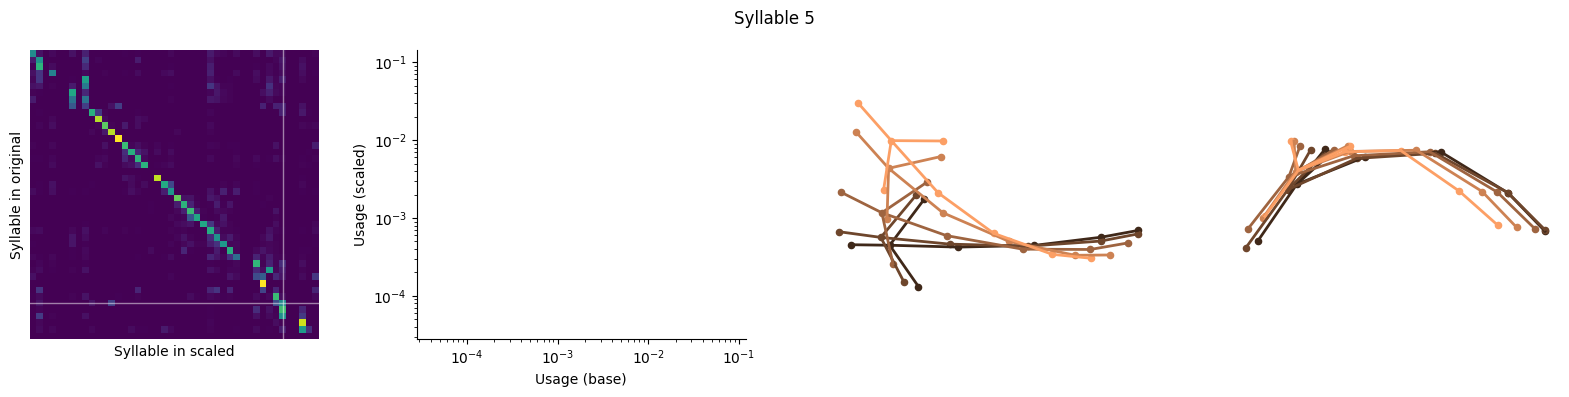

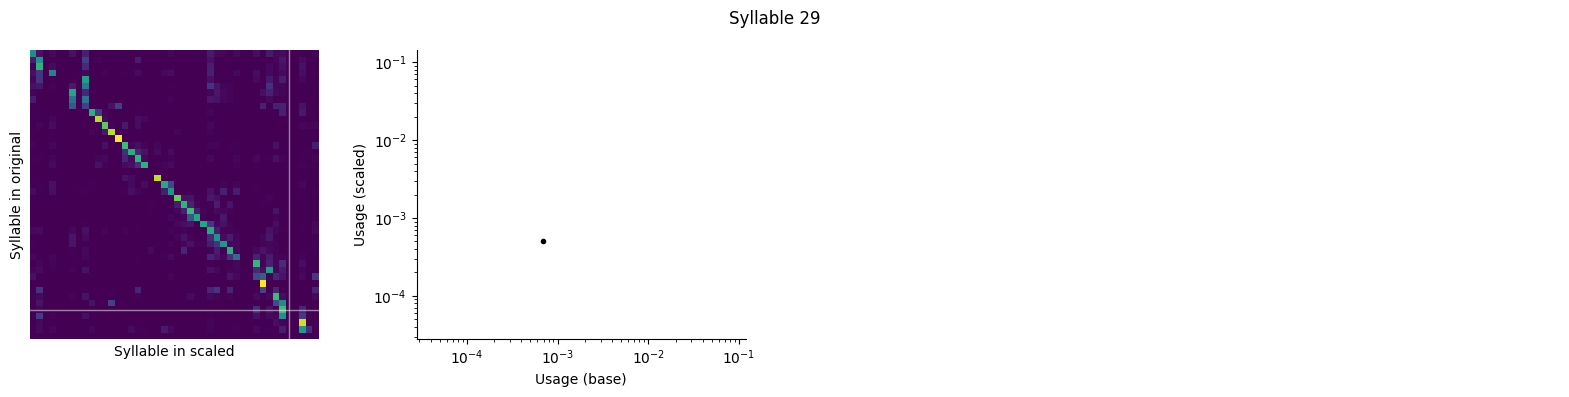

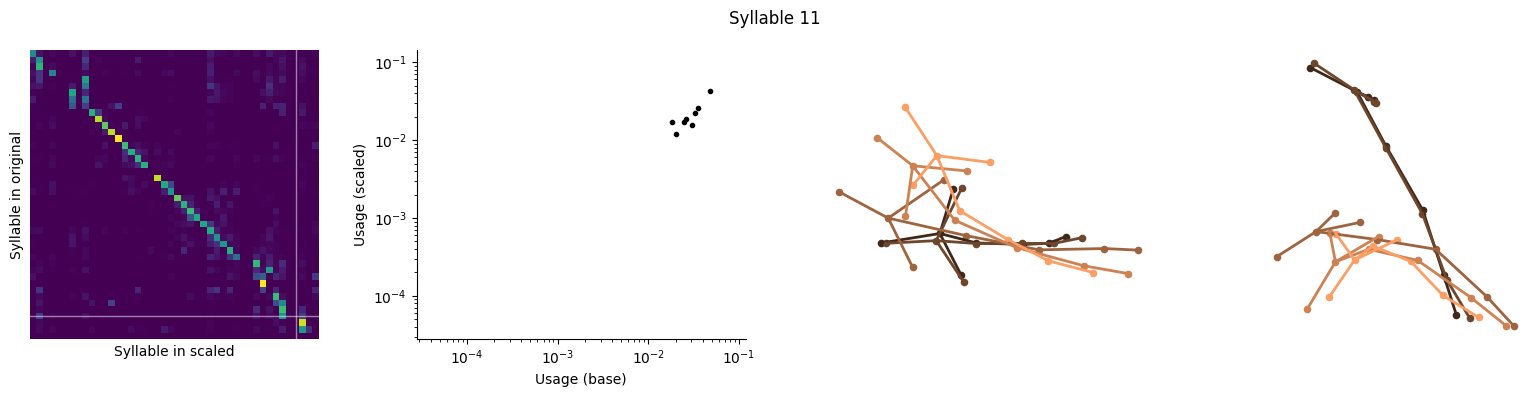

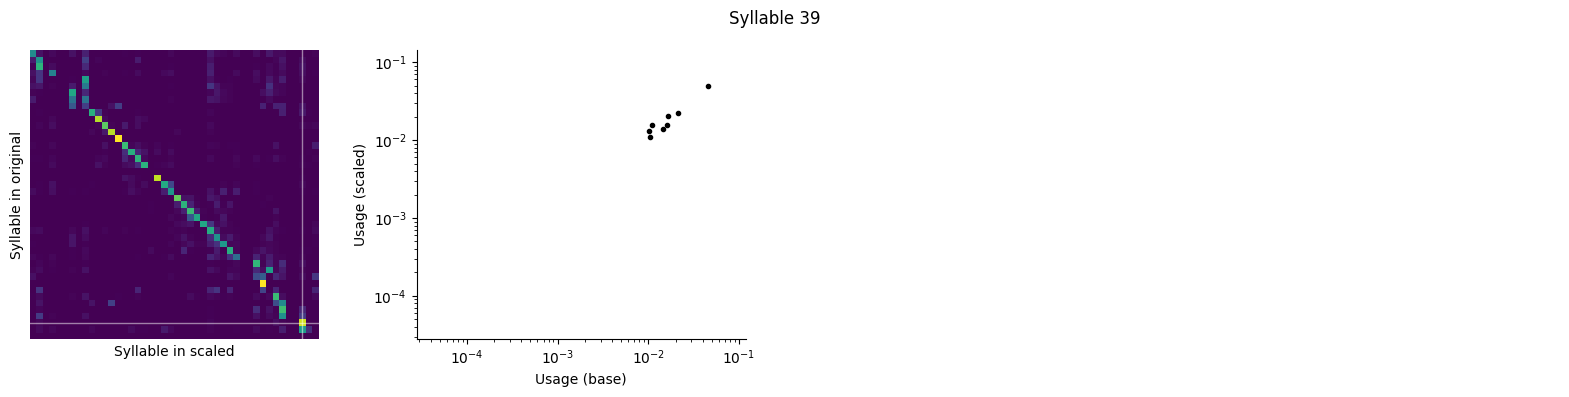

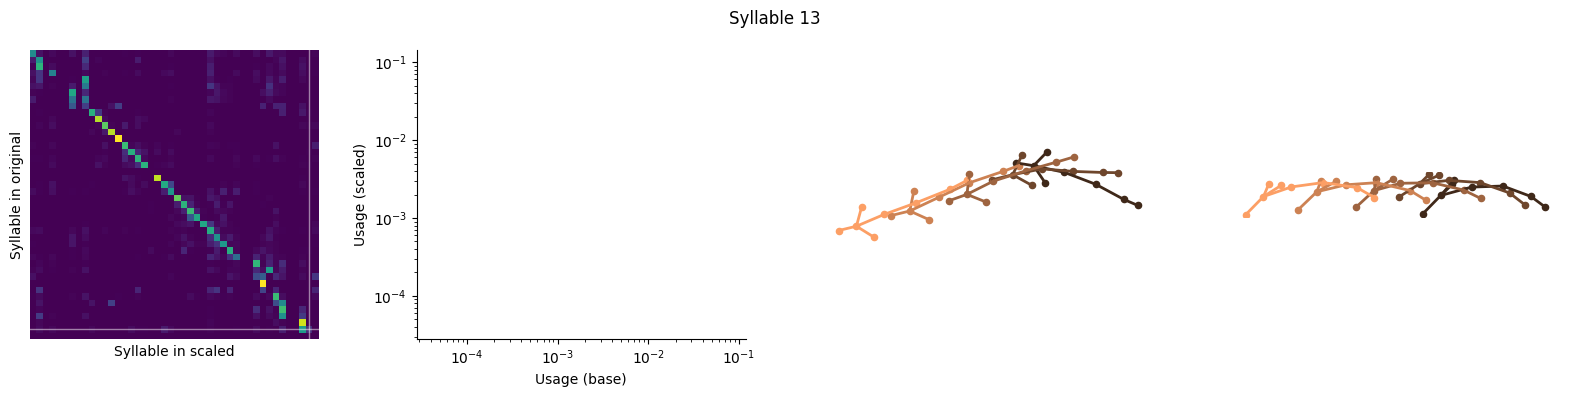

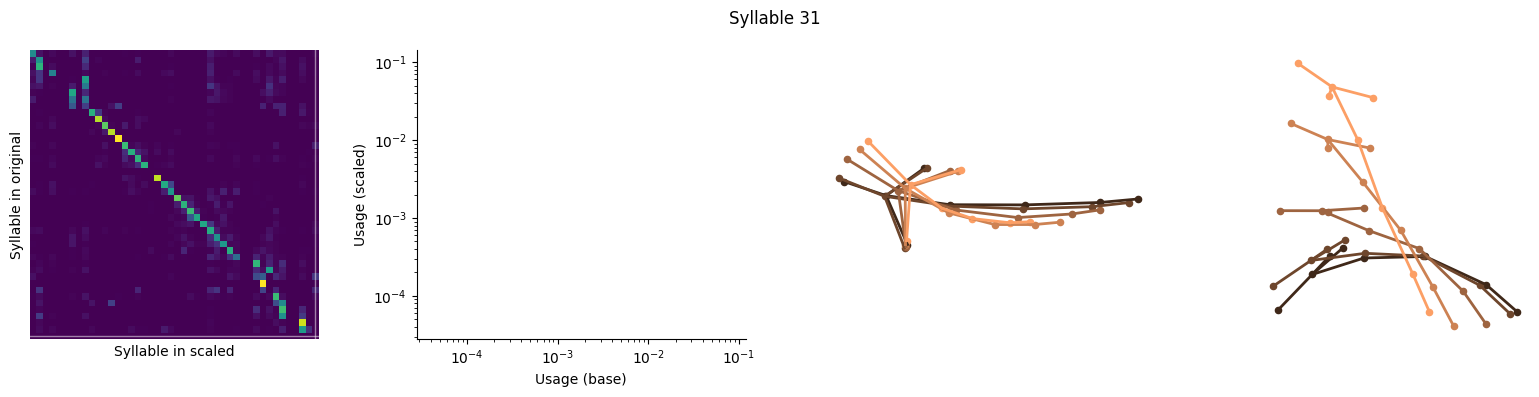

In [179]:
plot_X, plot_Y = np.meshgrid(np.arange(len(confusion)), np.arange(len(confusion))[::-1])
all_usages_pre  = np.array([frame_pcts[f'{rec}_f1']  [syll] for rec in recs for syll in order_clustered])
all_usages_post = np.array([frame_pcts[f'{rec}_f1.3'][syll] for rec in recs for syll in order_clustered])
pre_min, pre_max = all_usages_pre[all_usages_pre > 0].min(), all_usages_pre[all_usages_pre > 0].max()
post_min, post_max = all_usages_post[all_usages_post > 0].min(), all_usages_post[all_usages_post > 0].max()
frames_plot = [0, 4, 9, 15, 19]
frame_colors = mpl.colormaps['copper'](np.linspace(0.2, 0.8, len(frames_plot)))

for syll_i, syll in enumerate(order_clustered):

    fig, ax = plt.subplots(1, 4, figsize = (16, 4))

    ax[0].pcolormesh(plot_X, plot_Y, confusion)
    ax[0].set_ylabel("Syllable in original")
    ax[0].set_xlabel("Syllable in scaled")
    ax[0].set_aspect(1.)
    ax[0].axhline(plot_Y[syll_i, syll_i], color = (1., 1., 1., 0.5), lw = 1)
    ax[0].axvline(plot_X[syll_i, syll_i], color = (1., 1., 1., 0.5), lw = 1)
    ax[0].set_xticks([]); ax[0].set_yticks([])
    sns.despine(ax = ax[0], left = True, bottom = True)

    ax[1].plot(
        [frame_pcts[f'{rec}_f1'][syll] for rec in recs],
        [frame_pcts[f'{rec}_f1.3'][syll] for rec in recs],
        'o', ms = 3, color = 'k')
    ax[1].plot([pre_min, post_min], [pre_max, post_max])
    ax[1].set_xlim(pre_min, pre_max)
    ax[1].set_ylim(post_min, post_max)
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    ax[1].set_xlabel("Usage (base)")
    ax[1].set_ylabel("Usage (scaled)")
    sns.despine(ax = ax[1])

    if syll in syll_trajs:
        for a, (xaxis, yaxis) in [(ax[2], (0, 1)), (ax[3], (0, 2))]:
            for i, frame in enumerate(frames_plot):
                viz.bodies.plot_mouse_2d(
                    a, syll_trajs[syll][frame], xaxis, yaxis,
                    scatter_kw = {'color': frame_colors[i], 's': 20},
                    line_kw = {'color': frame_colors[i], 'lw': 2},
                    **config())
    ax[2].set_axis_off()
    ax[3].set_axis_off()
    
    fig.suptitle(f"Syllable {syll}")
    fig.tight_layout()
    plt.show()

### Twoscale with controls

In [6]:
results_main = jl.load(f'{results_dir("main")}/pop-results.p')
results_dup = jl.load(f'{results_dir("seed1")}/pop-results.p')

syllseqs_main = {k: r['syllable'] for k, r in results_main.items()}
syllseqs_dup = {k: r['syllable'] for k, r in results_dup.items()}

# recs = [k.split('f')[0][:-1] for k in results_main.keys() if k.endswith("f1")]
recs =  [k.split(':')[0] for k in results_main.keys() if k.endswith('3wk')]

sylls = viz.confusion.tree_unique([syllseqs_main, syllseqs_dup])


##### Usage distribution distances

In [7]:
counts_main = {k: lib.measure.syll_counts(seq, sylls) for k, seq in syllseqs_main.items()}
counts_dup = {k: lib.measure.syll_counts(seq, sylls) for k, seq in syllseqs_dup.items()}
pcts_main = {k: ct / ct.sum() for k, ct in counts_main.items()}
pcts_dup = {k: ct / ct.sum() for k, ct in counts_dup.items()}
ini_k = ':3wk'
alt_k = ':52wk'

# distances to larger self and self during reseeded run
scale_factor = 1.3
sized_dists = [lib.measure.jsd(
    counts_main[f'{r}{ini_k}'], counts_main[f'{r}{alt_k}']) for r in recs]
rerun_dists = [lib.measure.jsd(
    counts_main[f'{r}{ini_k}'], counts_dup[f'{r}{ini_k}']) for r in recs]

# within-size-cohort usage distribution distances
within_orig = [
    lib.measure.jsd(counts_main[f'{r1}{ini_k}'], counts_main[f'{r2}{ini_k}'])
    for i, r1 in enumerate(recs) for r2 in recs[:i]]
within_scaled = [
    lib.measure.jsd(counts_main[f'{r1}{alt_k}'], counts_main[f'{r2}{alt_k}'])
    for i, r1 in enumerate(recs) for r2 in recs[:i]]

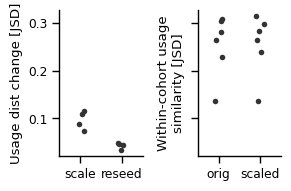

In [45]:
fig, ax = plt.subplots(1, 2, figsize = (3, 2), sharey = True)

N = len(sized_dists)
sns.stripplot(
    x = np.concatenate([np.full(N, "scale"),
                        np.full(N, "reseed")]),
    y = np.concatenate([sized_dists, rerun_dists]),
    ax = ax[0], color = '.2', s = 4,
)
N = len(within_orig)
sns.stripplot(
    x = np.concatenate([np.full(N, "orig"),
                        np.full(N, "scaled")]),
    y = np.concatenate([within_orig, within_scaled]),
    ax = ax[1], color = '.2', s = 4,
)
ax[0].set_ylabel("Usage dist change [JSD]")
ax[1].set_ylabel("Within-cohort usage\nsimilarity [JSD]")
ax[1].yaxis.get_label().set_visible(True)
sns.despine()
plt.tight_layout()
# fig.savefig(f"{plot_dir}/twoscale_usage_distances.png", dpi=300)
plt.show()

##### Syllable changes

In [55]:
# retention scores for each syllable
reusage_scale = np.array([
    np.diag(viz.confusion.confusion_matrix(syllseqs_main[f'{r}{ini_k}'], syllseqs_main[f'{r}{alt_k}'], sylls))
    for r in recs])
reusage_reseed = np.array([
    np.diag(viz.confusion.confusion_matrix(syllseqs_main[f'{r}{ini_k}'], syllseqs_dup[f'{r}{ini_k}'], sylls))
    for r in recs])
# masks of syllables used in original video
used_mask = [counts_main[f'{r}{ini_k}'] != 0 for r in recs]
# masks of syllables with low retention
lowret_scale  = [reusage_scale [i, used_mask[i]] < 0.5 for i in range(len(recs))]
lowret_reseed = [reusage_reseed[i, used_mask[i]] < 0.5 for i in range(len(recs))]
# pcts of used syllables with low retention
cutoff_reusage_scale  = [lowret_scale [i].mean() for i in range(len(recs))]
cutoff_reusage_reseed = [lowret_reseed[i].mean() for i in range(len(recs))]
# usage pcts of syllables with low retention
usage_lowret_scale  = np.concatenate([pcts_main[f'{r}{ini_k}'][used_mask[i]][ lowret_scale [i]] for i, r in enumerate(recs)]).ravel()
usage_lowret_reseed = np.concatenate([pcts_main[f'{r}{ini_k}'][used_mask[i]][ lowret_reseed[i]] for i, r in enumerate(recs)]).ravel()
usage_hiret_scale   = np.concatenate([pcts_main[f'{r}{ini_k}'][used_mask[i]][~lowret_scale [i]] for i, r in enumerate(recs)]).ravel()
usage_hiret_reseed  = np.concatenate([pcts_main[f'{r}{ini_k}'][used_mask[i]][~lowret_reseed[i]] for i, r in enumerate(recs)]).ravel()

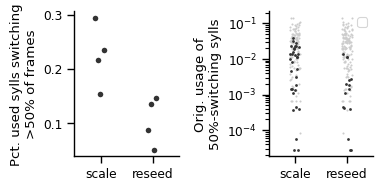

In [56]:
fig, ax = plt.subplots(1, 2, figsize = (4, 2))

N = len(recs)
sns.stripplot(
    x = np.concatenate([np.full(N, "scale"),
                        np.full(N, "reseed")]),
    y = np.concatenate([cutoff_reusage_scale, cutoff_reusage_reseed]),
    ax = ax[0], color = '.2', s = 4,
)
sns.stripplot(
    x = np.concatenate([np.full(usage_lowret_scale.size, "scale"),
                        np.full(usage_lowret_reseed.size, "reseed")]),
    y = np.concatenate([
            usage_lowret_scale,
            usage_lowret_reseed]),
    ax = ax[1], color = '.2', s = 2, zorder = 1
)
sns.stripplot(
    x = np.concatenate([np.full(usage_hiret_scale.size, "scale"),
                        np.full(usage_hiret_reseed.size, "reseed")]),
    y = np.concatenate([
            usage_hiret_scale,
            usage_hiret_reseed]),
    ax = ax[1], color = '.8', s = 1.5, zorder = 0
)
# ax[1].scatter([1, 1], [np.nan, np.nan], color = '.2', s = 2, label = 'switching')
# ax[1].scatter([1], [np.nan], color = '.8', s = 1.5, label = 'other')

ax[0].set_ylabel("Pct. used sylls switching\n>50% of frames")
ax[1].set_yscale('log')
ax[1].set_ylabel("Orig. usage of\n50%-switching sylls")
ax[1].legend()
sns.despine()
fig.tight_layout()
# fig.savefig(f"{plot_dir}/twoscale_syll_switches.png", dpi=300)
plt.show()

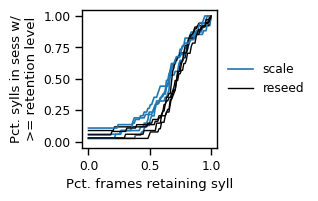

In [47]:
from scipy import stats

fig, ax = plt.subplots(1, 1, figsize = (3.2, 2.1))

for i in range(len(recs)):
    ecdf_reseed = stats.ecdf(reusage_reseed[i, used_mask[i]])
    ecdf_scale  = stats.ecdf(reusage_scale[i, used_mask[i]])
    x = np.linspace(0, 1, 100)
    ax.plot(x,  ecdf_scale.cdf.evaluate(x), 'C0-',
            label = 'scale' if i == 0 else None)
    ax.plot(x, ecdf_reseed.cdf.evaluate(x), 'k-', lw = 1,
            label = 'reseed' if i == 0 else None)
ax.set_ylabel("Pct. sylls in sess w/\n>= retention level")
ax.set_xlabel("Pct. frames retaining syll")
ax.set_ylim(-0.05, None)
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), frameon = False)
plt.tight_layout()
fig.savefig(f"{plot_dir}/twoscale_syll_switch_cdf.png", dpi=300)
plt.show()

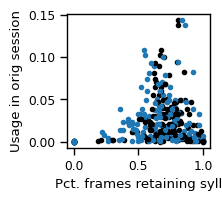

In [68]:
from scipy import stats

fig, ax = plt.subplots(1, 1, figsize = (2.3, 2.1))
# fig, ax = plt.subplots(1, 2, figsize = (4.3, 2.1), sharey = True)
ax = np.array([ax])

for i in range(len(recs)):
    ax[0].plot(reusage_reseed[i, used_mask[i]], pcts_main[f'{recs[i]}{ini_k}'][used_mask[i]], 'ko', ms = 3)
    ax[0].plot(reusage_scale [i, used_mask[i]], pcts_main[f'{recs[i]}{ini_k}'][used_mask[i]], 'C0o', ms = 3)
ax[0].set_ylabel("Usage in orig session")
ax[0].set_xlabel("Pct. frames retaining syll")
plt.tight_layout()
fig.savefig(f"{plot_dir}/twoscale_syll_switch_usage.png", dpi=300)
plt.show()

### Classifier-based



In [12]:
all_counts = {**{f'scl:{k}': v for k, v in counts_main.items()},
              **{f'dup:{k}': v for k, v in counts_dup.items()}}
scl_X, scl_Y = lib.separability.count_dict_to_feats_labels(
    all_counts, [
    [f'scl:{r}{ini_k}' for r in recs],
    [f'scl:{r}{alt_k}' for r in recs]])
dup_X, dup_Y = lib.separability.count_dict_to_feats_labels(
    all_counts, [
    [f'scl:{r}{ini_k}' for r in recs],
    [f'dup:{r}{ini_k}' for r in recs]])

scl_ini_X, _ = lib.separability.count_dict_to_feats_labels(
    all_counts, [[f'scl:{r}{ini_k}' for r in recs]])
scl_alt_X, _  = lib.separability.count_dict_to_feats_labels(
    all_counts, [[f'scl:{r}{alt_k}' for r in recs]])
dup_ini_X, _  = lib.separability.count_dict_to_feats_labels(
    all_counts, [[f'dup:{r}{ini_k}' for r in recs]])
dup_alt_X, _  = lib.separability.count_dict_to_feats_labels(
    all_counts, [[f'dup:{r}{alt_k}' for r in recs]])

scl_X, scl_scaler = lib.separability.whiten(scl_X)
dup_X, dup_scaler = lib.separability.whiten(dup_X)

# scl_scores = lib.separability.svc_crossval_scores(scl_X, scl_Y)
# dup_scores = lib.separability.svc_crossval_scores(dup_X, dup_Y)

scl_pair_scores = lib.separability.svc_paired_diffs(scl_ini_X, scl_alt_X)
dup_pair_scores = lib.separability.svc_paired_diffs(scl_ini_X, dup_ini_X)
scd_pair_scores = lib.separability.svc_paired_diffs(dup_ini_X, dup_alt_X)
dul_pair_scores = lib.separability.svc_paired_diffs(scl_alt_X, dup_alt_X)

Liblinear failed to converge, increase the number of iterations.Liblinear failed to converge, increase the number of iterations.Liblinear failed to converge, increase the number of iterations.

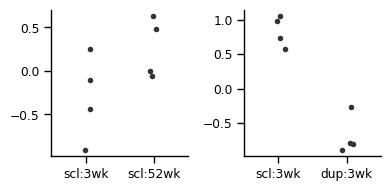

In [115]:
# basic cross-validated scores
fig, ax = plt.subplots(1, 2, figsize = (4, 2))

sns.stripplot(
    **viz.util.stripgroups(
        [f'scl{ini_k}', f'scl{alt_k}'],
        [scl_scores[scl_Y == 0], scl_scores[scl_Y == 1]]),
    ax = ax[0], color = '.2', s = 4,
)
sns.stripplot(
    **viz.util.stripgroups(
        [f'scl{ini_k}', f'dup{ini_k}'],
        [dup_scores[dup_Y == 0], dup_scores[dup_Y == 1]]),
    ax = ax[1], color = '.2', s = 4,
)
sns.despine()
fig.tight_layout()
plt.show()

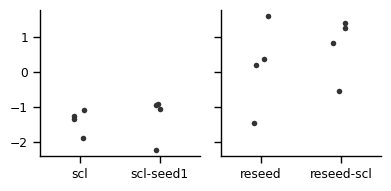

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (4, 2), sharey = True)

sns.stripplot(
    **viz.util.stripgroups(
        ['scl', 'scl-seed1'],
        [scl_pair_scores[0] - scl_pair_scores[1],
         scd_pair_scores[0] - scd_pair_scores[1]]),
    ax = ax[0], color = '.2', s = 4,
)
sns.stripplot(
    **viz.util.stripgroups(
        ['reseed', 'reseed-scl'],
        [dup_pair_scores[0] - dup_pair_scores[1],
         dul_pair_scores[0] - dul_pair_scores[1]]),
    ax = ax[1], color = '.2', s = 4,
)
sns.despine()
fig.tight_layout()
plt.show()

(2, 4)